In [ ]:
# Interpretable application of machine learning techniques in the assessment of coastal water quality of Poyang Lake (China)
# Hu et al Supplementary Data S1
# dataset: LBanghu.xlsx

############################################
### Section 1: MLMs&SHAP analysis for TN ###
############################################

#######################################
### 1.1: Model Training & Selection ###
#######################################

# ================= Import Required Libraries =================
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ================= Upload Dataset =================
uploaded = files.upload()  # choose file from the file path, file name “LBanghu.xlsx”
file_name = list(uploaded.keys())[0]
data = pd.read_excel(file_name)

# ================= Normality Tested Variables in this study =================
normal_vars = ["TP", "pH", "ORP"]  # Normally distributed variables
non_normal_vars = ["T", "DO", "EC", "Chla", "TN", "TDS"]  # Non-normally distributed variables

#======= Handling Non-Normally Distributed Variables (Quantile Transformation) ========
transformer = QuantileTransformer(output_distribution='uniform', random_state=42, n_quantiles=len(data))
data[non_normal_vars] = transformer.fit_transform(data[non_normal_vars])
print("✅ Non-normally distributed variables are transformed. Normally distributed variables remain unchanged.")

# ================= Handling Missing and Infinite Values =================
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# ================= Split Dataset =================
X = data.drop(columns=['T', 'DO', 'EC', 'ORP', 'pH', 'TDS'])  # Features
y = data['TN']  # Target variable

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ================= Hyperparameter Grids =================
param_grid = {
    "SVR": {
        "kernel": ['rbf'],
        "C": [0.1, 1, 5, 10],
        "epsilon": [0.01, 0.05, 0.1],
        "gamma": ['scale', 'auto']
    },
    "Random Forest": {
        "n_estimators": [100, 200, 500],
        "max_depth": [None, 4, 6, 8],
        "min_samples_split": [2, 4, 6]
    },
    "XGBoost": {
        "n_estimators": [100, 200, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "reg_lambda": [1, 2, 5]
    },
    "KNN": {
        "n_neighbors": [3, 5, 10],
        "weights": ['uniform', 'distance']
    }
}

# ================= Model Training =================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_models = {}
results = []

for name, model in [
    ("SVR", SVR()),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42)),
    ("KNN", KNeighborsRegressor())
]:
    print(f"🔍 Optimizing {name}...")
    grid_search = GridSearchCV(model, param_grid[name], cv=kf, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Evaluation Metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    cv_r2 = cross_val_score(best_model, X_scaled, y, cv=kf, scoring='r2').mean()

    results.append([name, train_mse, test_mse, train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2, cv_r2])

    print(f"✅ Best Parameters: {grid_search.best_params_}")
    print(f"✅ R² (Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}, CV R2: {cv_r2:.4f})\n")

# ================= Export Results =================
results_df = pd.DataFrame(results, columns=["Model", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", "Train MAE", "Test MAE", "Train R²", "Test R²", "CV R²"])

results_df.to_excel("final_model_results_TN.xlsx", index=False)
files.download("final_model_results_TN.xlsx")
print("✅ Final results saved to 'final_model_results_TN.xlsx'")

Saving LBanghu.xlsx to LBanghu.xlsx
✅ Non-normally distributed variables are transformed. Normally distributed variables remain unchanged.
🔍 Optimizing SVR...
✅ Best Parameters: {'C': 1, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
✅ R² (Train R2: 0.9988, Test R2: 0.8781, CV R2: 0.8730)

🔍 Optimizing Random Forest...
✅ Best Parameters: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 500}
✅ R² (Train R2: 0.9966, Test R2: 0.9621, CV R2: 0.9801)

🔍 Optimizing XGBoost...
✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 5}
✅ R² (Train R2: 0.9983, Test R2: 0.9685, CV R2: 0.9293)

🔍 Optimizing KNN...
✅ Best Parameters: {'n_neighbors': 3, 'weights': 'distance'}
✅ R² (Train R2: 1.0000, Test R2: 0.9360, CV R2: 0.8306)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Final results saved to 'final_model_results_TN.xlsx'


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


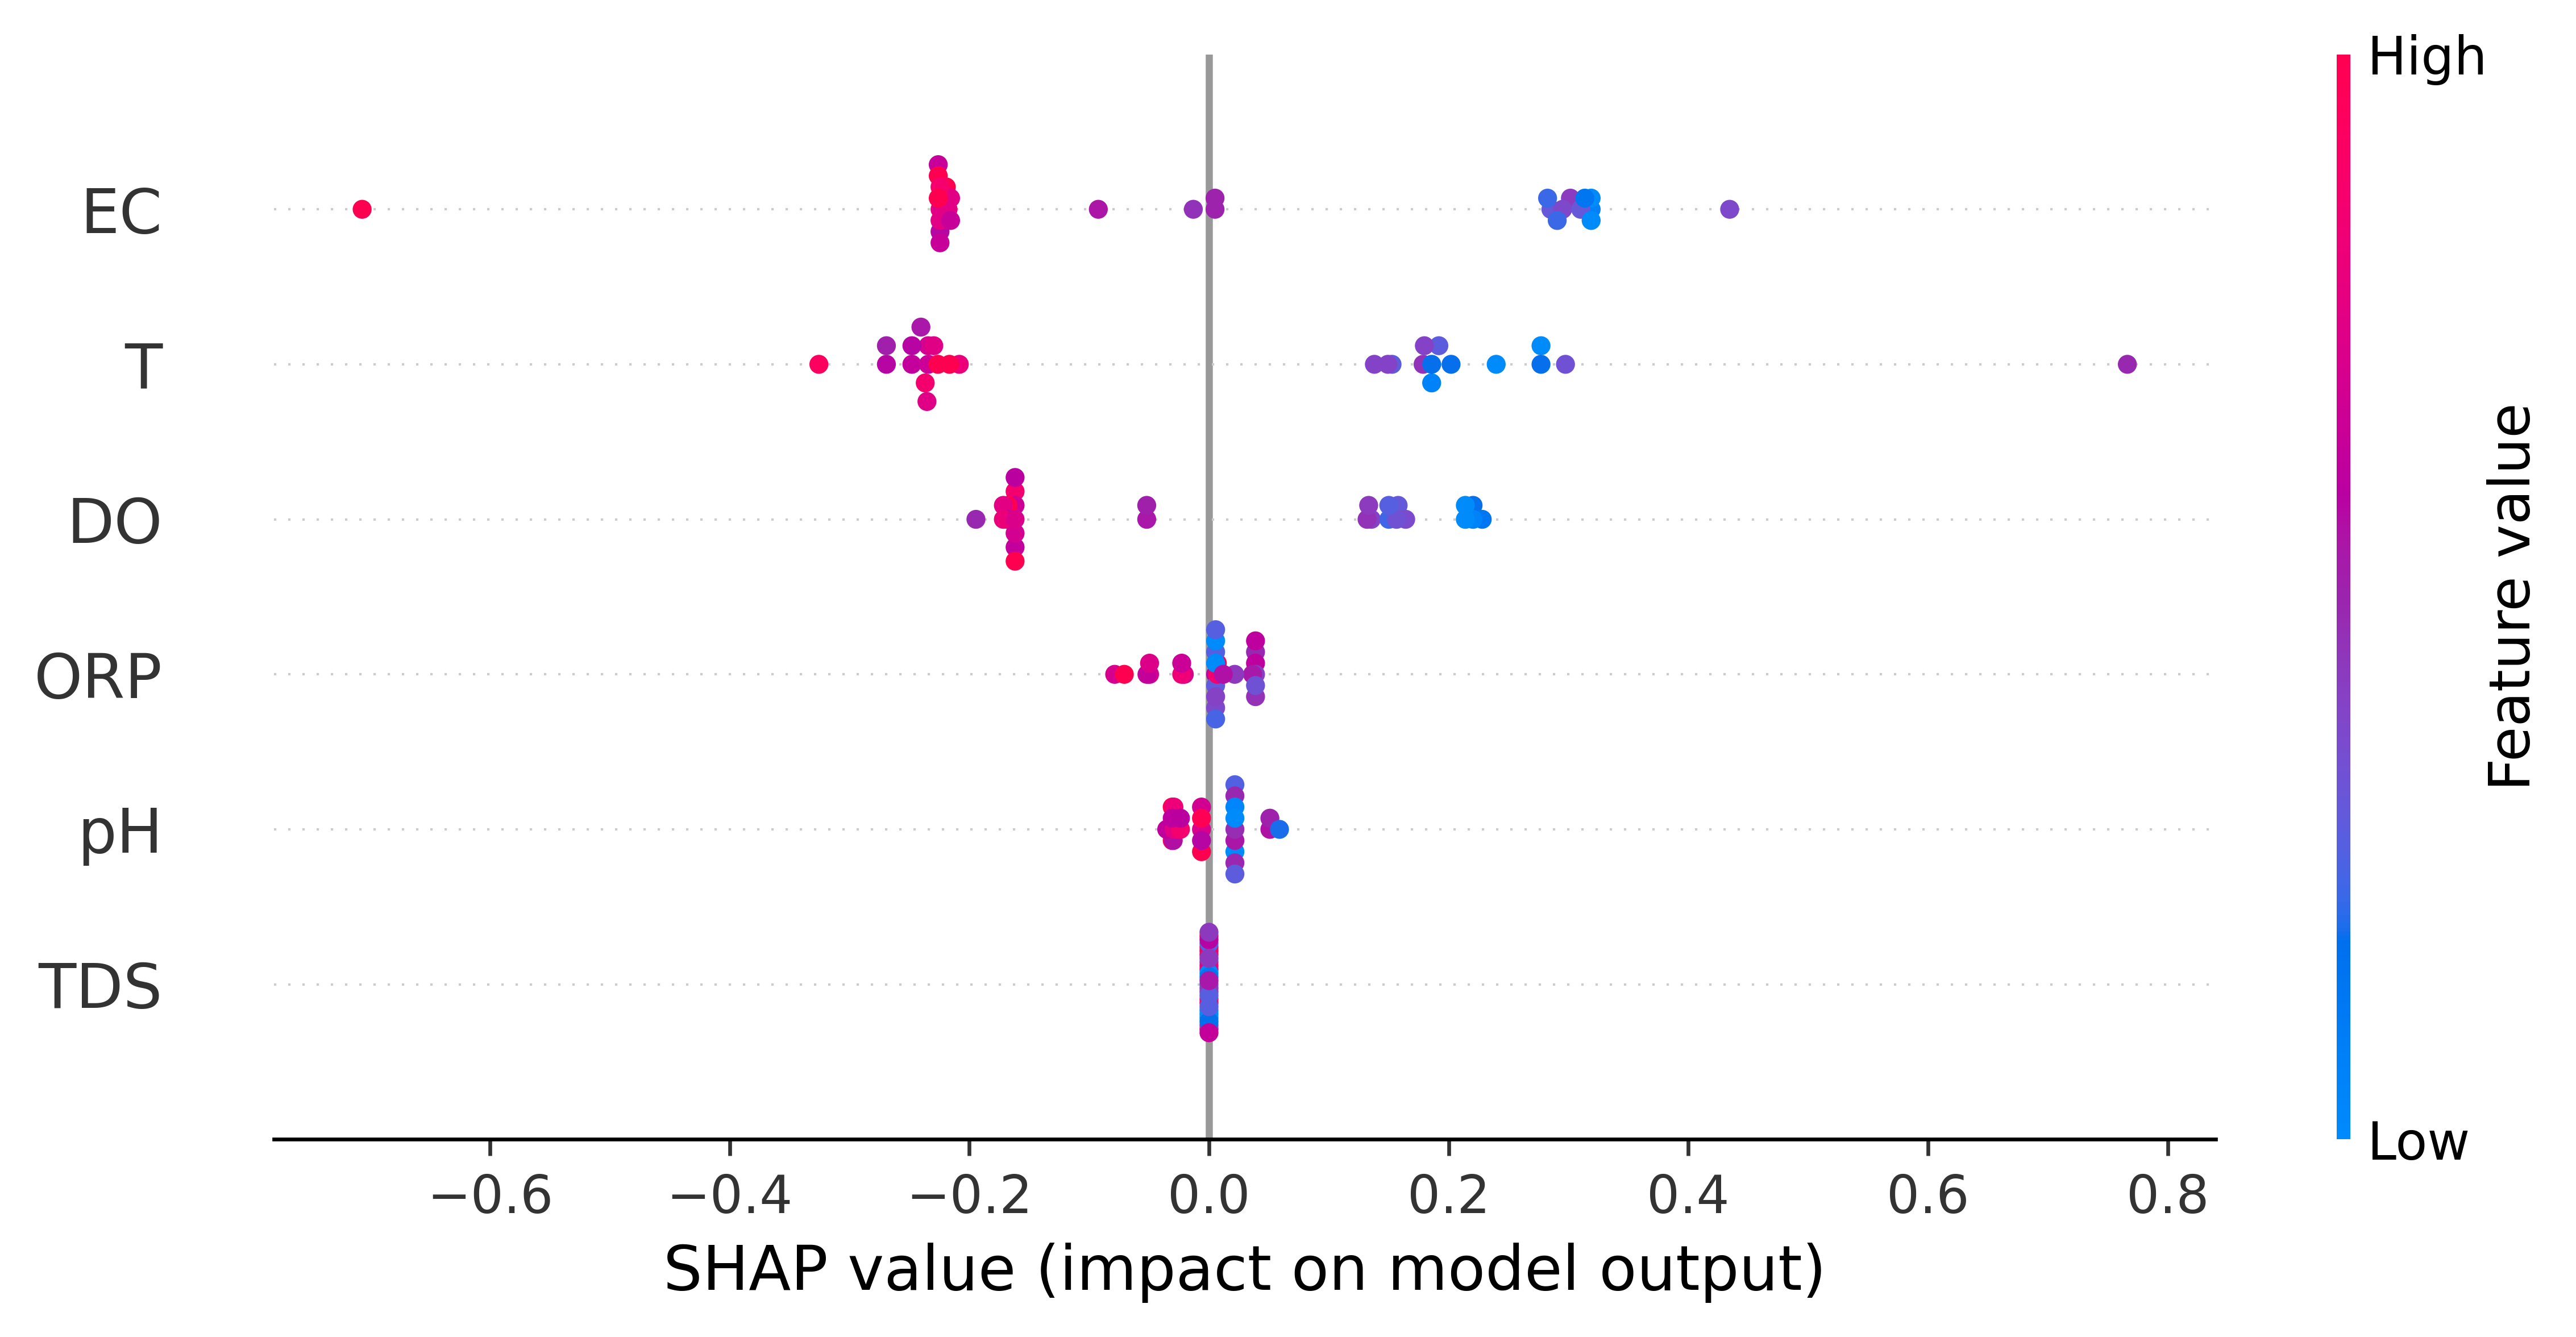

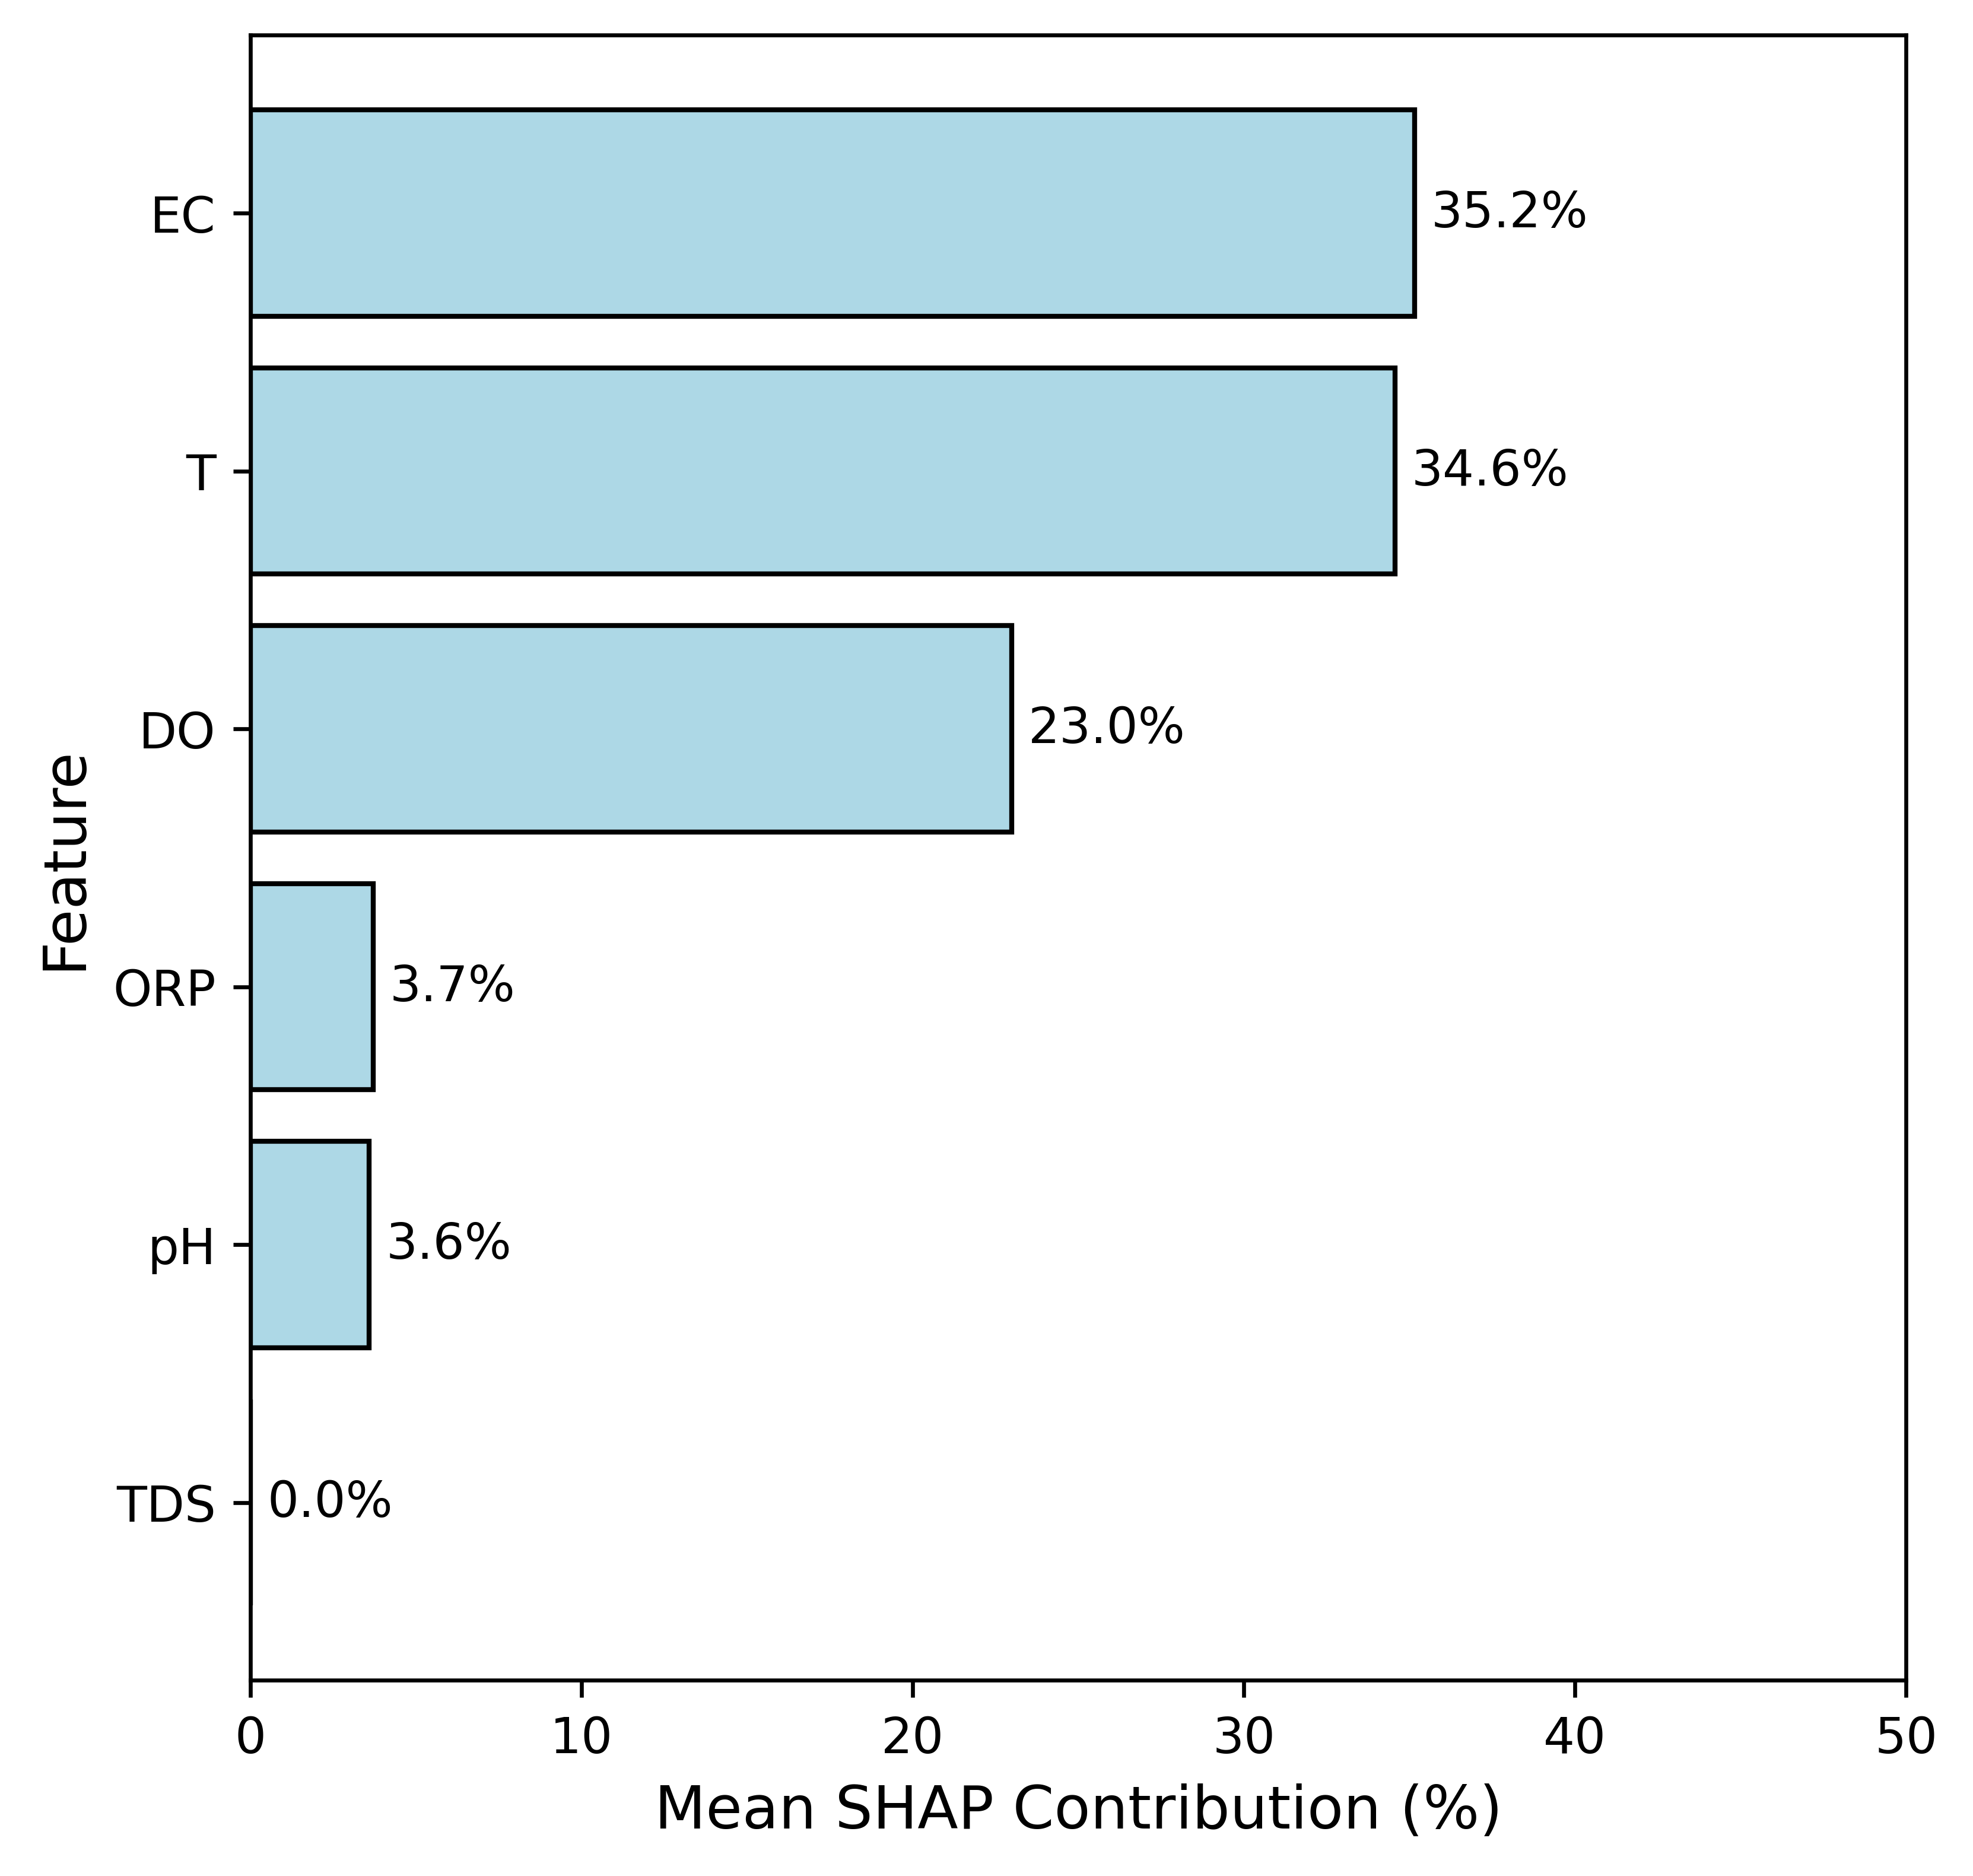

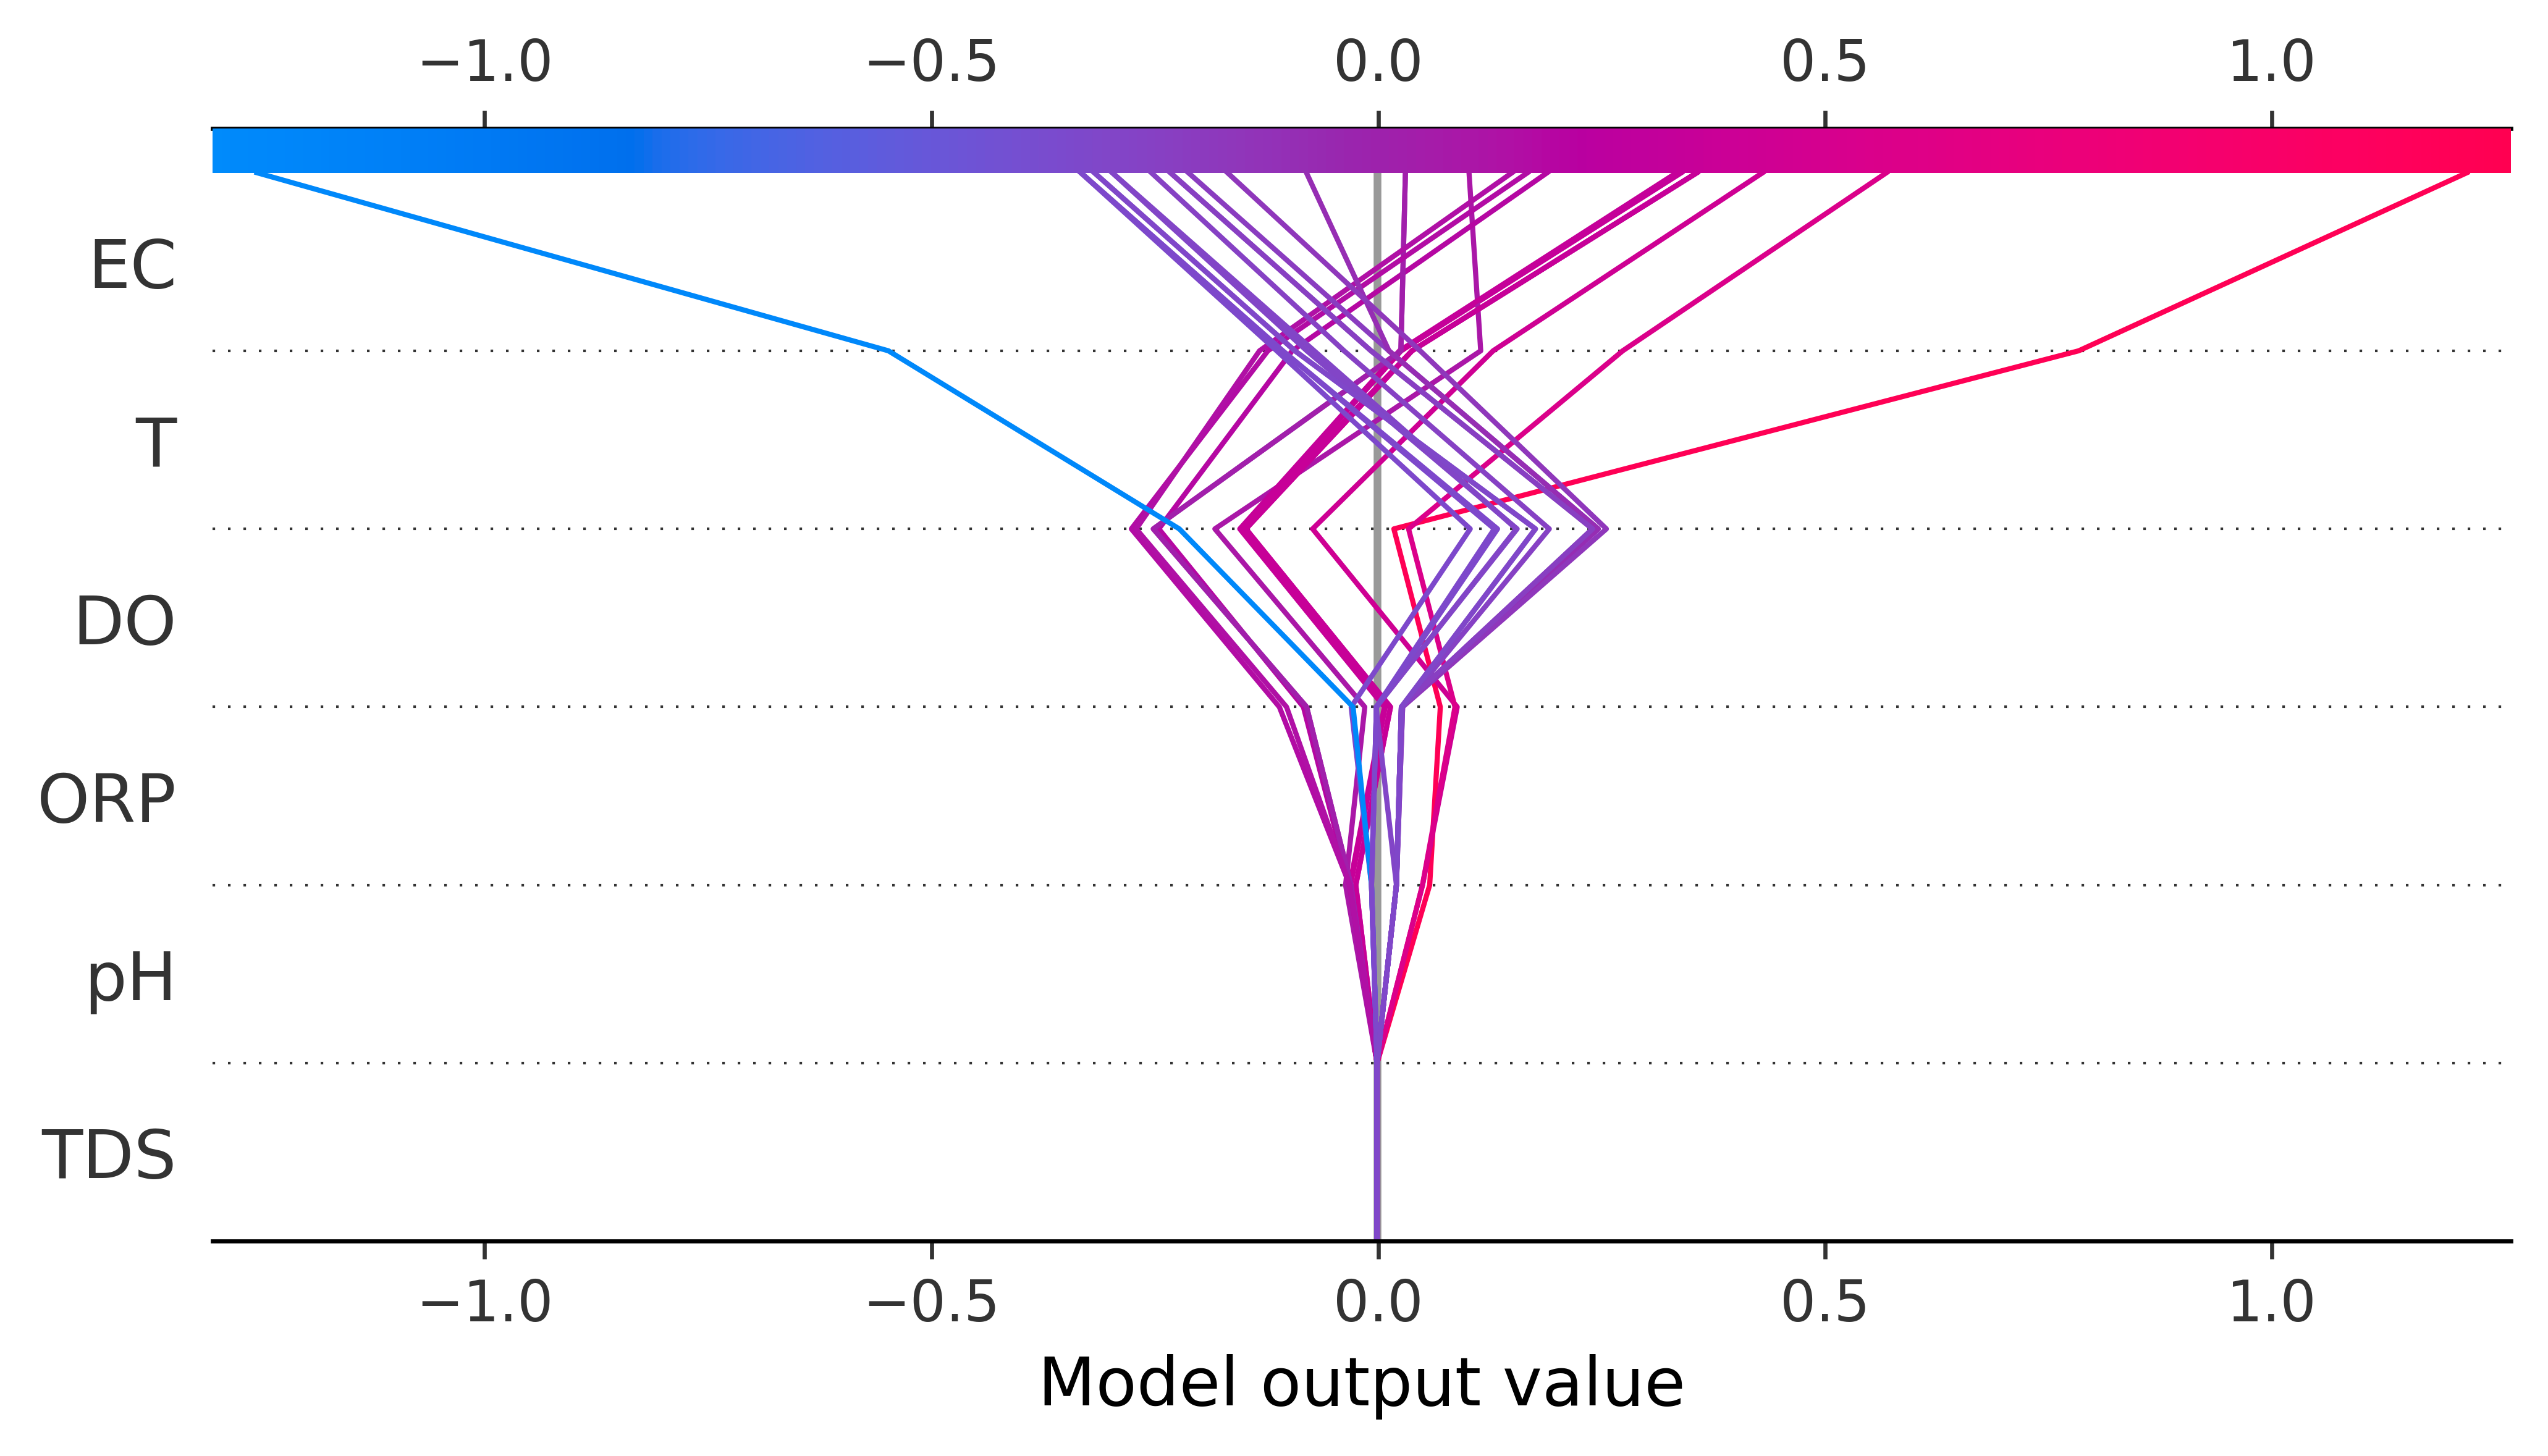

✅ SHAP results saved to 'shap_results_TN.xlsx'

Preview of SHAP contributions:
   Sample         T        DO        EC       ORP        pH  TDS
0       1  0.766348 -0.051959  0.434487  0.011900  0.058837  0.0
1       2  0.179721 -0.161806  0.313623  0.038827 -0.029834  0.0
2       3  0.185818 -0.161806  0.318902  0.038827 -0.023822  0.0
3       4  0.297489 -0.167752 -0.013069  0.021485 -0.035274  0.0
4       5  0.202006 -0.161806  0.301598  0.038827  0.050821  0.0

Average SHAP Contributions (%):
  Feature  Mean SHAP (%)
5     TDS       0.000000
4      pH       3.587500
3     ORP       3.701620
1      DO      22.989927
0       T      34.563912
2      EC      35.157041


In [ ]:
####################################
### 1.2: XGBoost & SHAP analysis ###
####################################

# ================= Install Required Packages =================
!pip install shap xgboost openpyxl

# ================= Import Libraries =================
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from google.colab import files

plt.rcParams['font.family'] = ['sans-serif']  # font style
plt.rcParams['font.size'] = 6  # font size

# ================= Upload Dataset =================
data = pd.read_excel("LBanghu.xlsx")

# ================= Define Variable Groups =================
normal_vars = ['TP', 'pH', 'ORP']  # normally distributed variables
non_normal_vars = ['T', 'DO', 'EC', 'Chla', 'TN', 'TDS']  # non-normally distributed variables

# ================= Data Processing =================
quantile_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=len(data))  # convert to a normal distribution
data[non_normal_vars] = quantile_transformer.fit_transform(data[non_normal_vars])
scaler = StandardScaler()  # standardization
data[normal_vars + non_normal_vars] = scaler.fit_transform(data[normal_vars + non_normal_vars])

# ================= Split Dataset =================
X = data[['T', 'DO', 'EC', 'ORP', 'pH', 'TDS']]
y = data['TN']  # Target variable

# ================= XGBoost Parameter Tuning =================
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2
)
grid_search.fit(X, y)
best_xgb = grid_search.best_estimator_

# ================= SHAP Analysis =================
explainer = shap.Explainer(best_xgb, X)
shap_values = explainer(X)

shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_df.insert(0, 'Sample', range(1, len(shap_df) + 1))

shap_mean = shap_df.drop(columns=['Sample']).abs().mean()
shap_percent = (shap_mean / shap_mean.sum()) * 100
shap_summary_df = pd.DataFrame({'Feature': shap_percent.index, 'Mean SHAP (%)': shap_percent.values})

# ================= Export SHAP data =================
with pd.ExcelWriter('shap_results.xlsx', engine='openpyxl') as writer:
    shap_df.to_excel(writer, sheet_name='SHAP Contributions', index=False)
    shap_summary_df.to_excel(writer, sheet_name='Mean SHAP Values', index=False)

# ================= Visualizations =================
# Summary Plot
plt.figure(figsize=(6, 8), dpi=600)
shap.summary_plot(shap_values, X, show=False)
plt.savefig('shap_summary_plot.png', dpi=600, bbox_inches='tight')
plt.show()

# Bar Chart (contribution, %)
fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
shap_summary_df = shap_summary_df.sort_values(by="Mean SHAP (%)", ascending=True)
plt.barh(shap_summary_df['Feature'], shap_summary_df['Mean SHAP (%)'], color='lightblue', edgecolor='black')
plt.xlabel("Mean SHAP Contribution (%)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xlim(0, 50.0)
for index, value in enumerate(shap_summary_df["Mean SHAP (%)"]):
    plt.text(value + 0.5, index, f"{value:.1f}%", va='center', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('shap_bar_chart.png', dpi=600, bbox_inches='tight')
plt.show()

# SHAP Decision Plot
shap_values_numpy = shap_values.values
base_value = explainer.expected_value

fig, ax = plt.subplots(figsize=(6, 8), dpi=600)
shap.decision_plot(base_value, shap_values_numpy, X.columns, link='identity', show=False)
plt.savefig("shap_decision_plot.png", bbox_inches='tight', dpi=600)
plt.show()

print("✅ SHAP results saved to 'shap_results_TN.xlsx'")
print("\nPreview of SHAP contributions:")
print(shap_df.head())
print("\nAverage SHAP Contributions (%):")
print(shap_summary_df)

✅ Evaluation for TN (original scale) — R²: 0.9968, RMSE: 0.0187, MAE: 0.0071


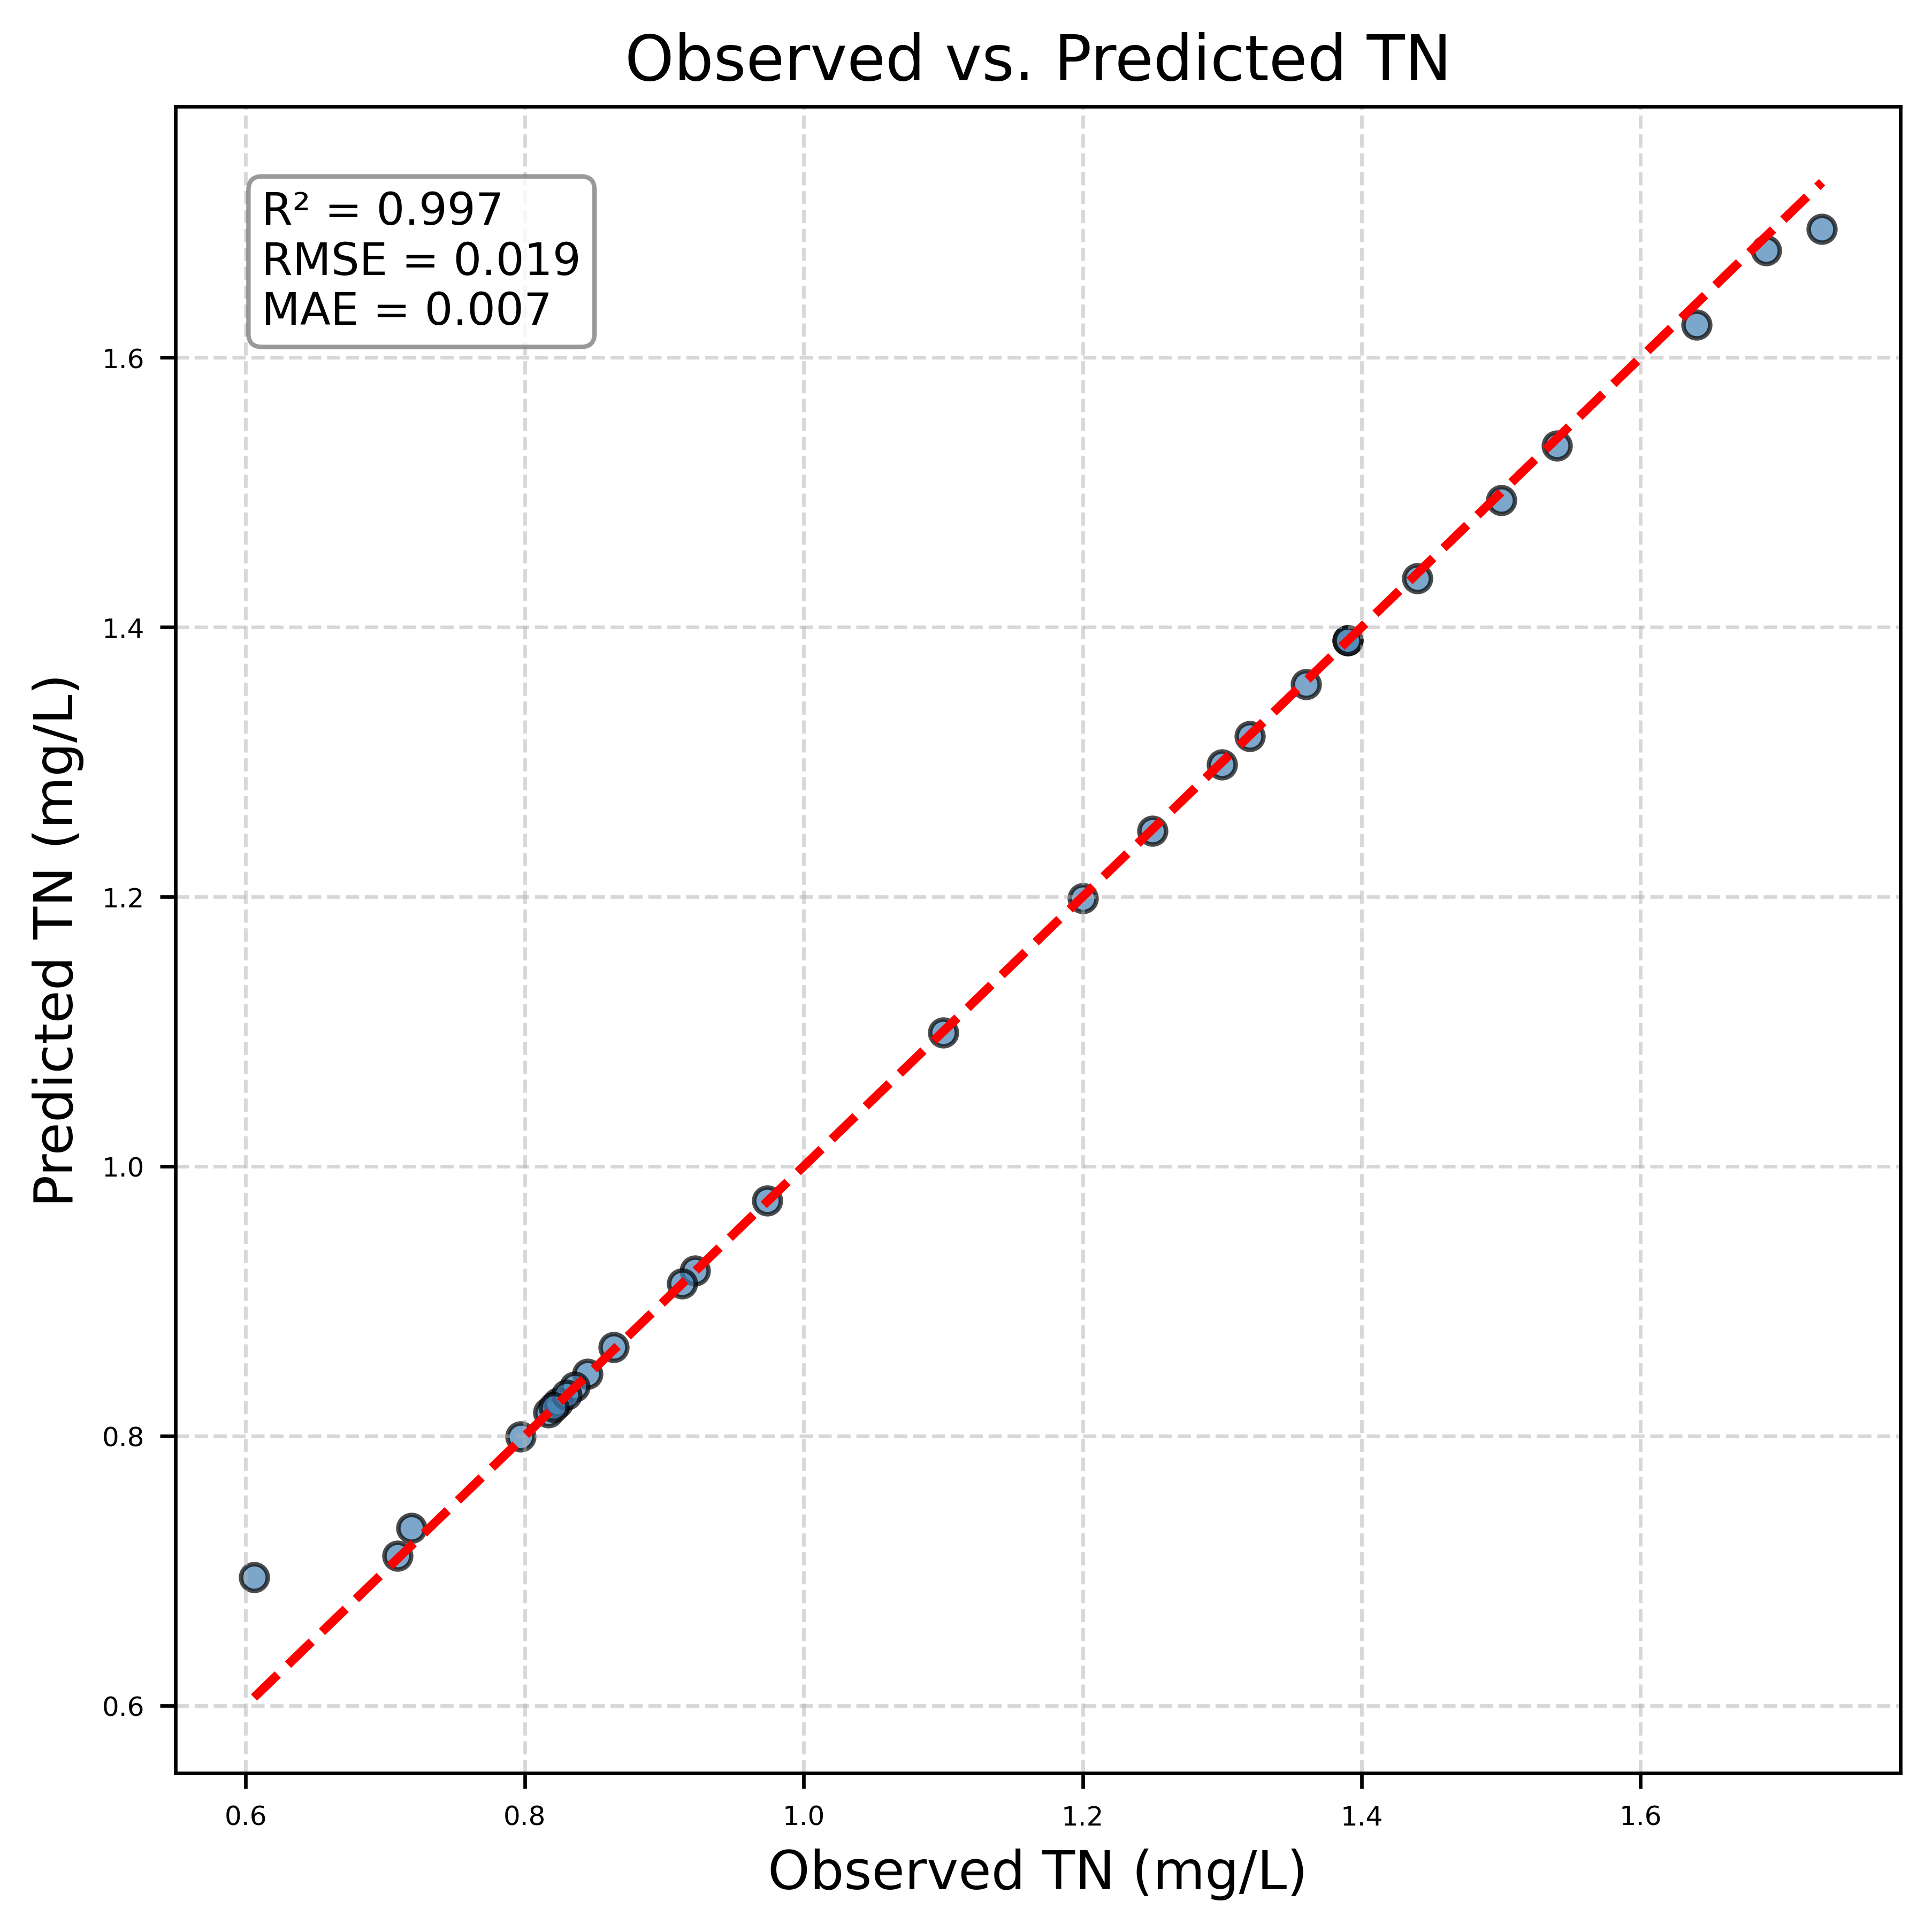

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Prediction results saved as TN_Predictions_TN.xlsx


In [ ]:
###############################
### 1.3: XGBoost Prediction ###
###############################

# ================= Import Required Libraries =================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from xgboost import XGBRegressor
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ================= Configuration Parameters =================
TARGET_VAR = "TN"  # Target variable
DROP_COLS = ['T', 'DO', 'EC', 'ORP', 'pH', 'TDS']  # Variables to drop from X (adjust as needed)

# ================= Upload Dataset =================
data = pd.read_excel("LBanghu.xlsx")

# ================= Store Original Target for Evaluation =================
original_target = data[TARGET_VAR].copy()

# ================= Define Normality =================
normal_vars = ["TP", "pH", "ORP"]
non_normal_vars = ["T", "DO", "EC", "Chla", "TN", "TDS"]

# ================= Apply Quantile Transformation to Non-Normal Vars =================
transformer = QuantileTransformer(output_distribution='uniform', random_state=42, n_quantiles=len(data))
data[non_normal_vars] = transformer.fit_transform(data[non_normal_vars])

# ================= Clean the Data =================
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# ================= Feature and Target Definition =================
X = data.drop(columns=DROP_COLS + [TARGET_VAR] if TARGET_VAR in DROP_COLS else DROP_COLS)
y = data[TARGET_VAR]

# ================= Standardize Features =================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ================= Train XGBoost Model =================
model = XGBRegressor(
    learning_rate=0.05,
    max_depth=3,
    n_estimators=100,
    reg_lambda=1,
    random_state=42
)
model.fit(X_scaled, y)

# ================= Make Prediction =================
y_pred = model.predict(X_scaled)

# ================= Inverse Transform If Target Was Non-Normal =================
if TARGET_VAR in non_normal_vars:
    temp_df = data[non_normal_vars].copy()
    temp_df[TARGET_VAR] = y
    temp_df_pred = data[non_normal_vars].copy()
    temp_df_pred[TARGET_VAR] = y_pred

    y_original = transformer.inverse_transform(temp_df)[:, non_normal_vars.index(TARGET_VAR)]
    y_pred_original = transformer.inverse_transform(temp_df_pred)[:, non_normal_vars.index(TARGET_VAR)]
else:
    y_original = y
    y_pred_original = y_pred

# ================= Evaluation Metrics =================
r2 = r2_score(y_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_original, y_pred_original))
mae = mean_absolute_error(y_original, y_pred_original)

print(f"✅ Evaluation for {TARGET_VAR} (original scale) — R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# ================= Visualization =================
plt.figure(figsize=(6, 6), dpi=600)
plt.scatter(y_original, y_pred_original, alpha=0.7, color='steelblue', edgecolor='k')
plt.plot([y_original.min(), y_original.max()],
         [y_original.min(), y_original.max()],
         'r--', lw=2)

plt.xlabel(f'Observed {TARGET_VAR} (mg/L)', fontsize=12)
plt.ylabel(f'Predicted {TARGET_VAR} (mg/L)', fontsize=12)
plt.title(f'Observed vs. Predicted {TARGET_VAR}', fontsize=14)

# Text box for metrics
textstr = f'R² = {r2:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='left',
         bbox=props, fontsize=10)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f"{TARGET_VAR}_Observed_vs_Predicted.tiff", dpi=600, format='tiff')
plt.show()

# ================= Save and Export Results =================
results_df = pd.DataFrame({
    f'Actual_{TARGET_VAR}_Original': y_original,
    f'Predicted_{TARGET_VAR}_Original': y_pred_original
})
output_filename = f"{TARGET_VAR}_Predictions_TN.xlsx"
results_df.to_excel(output_filename, index=False)
files.download(output_filename)
print(f"✅ Prediction results saved as {output_filename}")

In [ ]:
############################################
### Section 2: MLMs&SHAP analysis for TP ###
############################################

#######################################
### 2.1: Model Training & Selection ###
#######################################

# ================= Import Required Libraries =================
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ================= Upload Dataset =================
data = pd.read_excel("LBanghu.xlsx")

# ================= Normality Tested Variables in this study =================
normal_vars = ["TP", "pH", "ORP"]  # Normally distributed variables
non_normal_vars = ["T", "DO", "EC", "Chla", "TN", "TDS"]  # Non-normally distributed variables

#======= Handling Non-Normally Distributed Variables (Quantile Transformation) ========
transformer = QuantileTransformer(output_distribution='uniform', random_state=42, n_quantiles=len(data))
data[non_normal_vars] = transformer.fit_transform(data[non_normal_vars])
print("✅ Non-normally distributed variables are transformed. Normally distributed variables remain unchanged.")

# ================= Handling Missing and Infinite Values =================
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# ================= Split Dataset =================
X = data.drop(columns=['T', 'DO', 'EC', 'ORP', 'pH', 'TDS'])  # Features
y = data['TP']  # Target variable

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ================= Hyperparameter Grids =================
param_grid = {
    "SVR": {
        "kernel": ['rbf'],
        "C": [0.1, 1, 5, 10],
        "epsilon": [0.01, 0.05, 0.1],
        "gamma": ['scale', 'auto']
    },
    "Random Forest": {
        "n_estimators": [100, 200, 500],
        "max_depth": [None, 4, 6, 8],
        "min_samples_split": [2, 4, 6]
    },
    "XGBoost": {
        "n_estimators": [100, 200, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "reg_lambda": [1, 2, 5]
    },
    "KNN": {
        "n_neighbors": [3, 5, 10],
        "weights": ['uniform', 'distance']
    }
}

# ================= Model Training =================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_models = {}
results = []

for name, model in [
    ("SVR", SVR()),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42)),
    ("KNN", KNeighborsRegressor())
]:
    print(f"🔍 Optimizing {name}...")
    grid_search = GridSearchCV(model, param_grid[name], cv=kf, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Evaluation Metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    cv_r2 = cross_val_score(best_model, X_scaled, y, cv=kf, scoring='r2').mean()

    results.append([name, train_mse, test_mse, train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2, cv_r2])

    print(f"✅ Best Parameters: {grid_search.best_params_}")
    print(f"✅ R² (Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}, CV R2: {cv_r2:.4f})\n")

# ================= Export Results =================
results_df = pd.DataFrame(results, columns=["Model", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", "Train MAE", "Test MAE", "Train R²", "Test R²", "CV R²"])

results_df.to_excel("final_model_results_TP.xlsx", index=False)
files.download("final_model_results_TP.xlsx")
print("✅ Final results saved to 'final_model_results_TP.xlsx'")

✅ Non-normally distributed variables are transformed. Normally distributed variables remain unchanged.
🔍 Optimizing SVR...
✅ Best Parameters: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
✅ R² (Train R2: 0.8556, Test R2: 0.6348, CV R2: 0.5742)

🔍 Optimizing Random Forest...
✅ Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
✅ R² (Train R2: 0.9744, Test R2: 0.8893, CV R2: 0.9029)

🔍 Optimizing XGBoost...
✅ Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 1}
✅ R² (Train R2: 0.9072, Test R2: 0.8615, CV R2: 0.7913)

🔍 Optimizing KNN...
✅ Best Parameters: {'n_neighbors': 3, 'weights': 'distance'}
✅ R² (Train R2: 1.0000, Test R2: 0.9082, CV R2: 0.6807)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Final results saved to 'final_model_results_TP.xlsx'


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


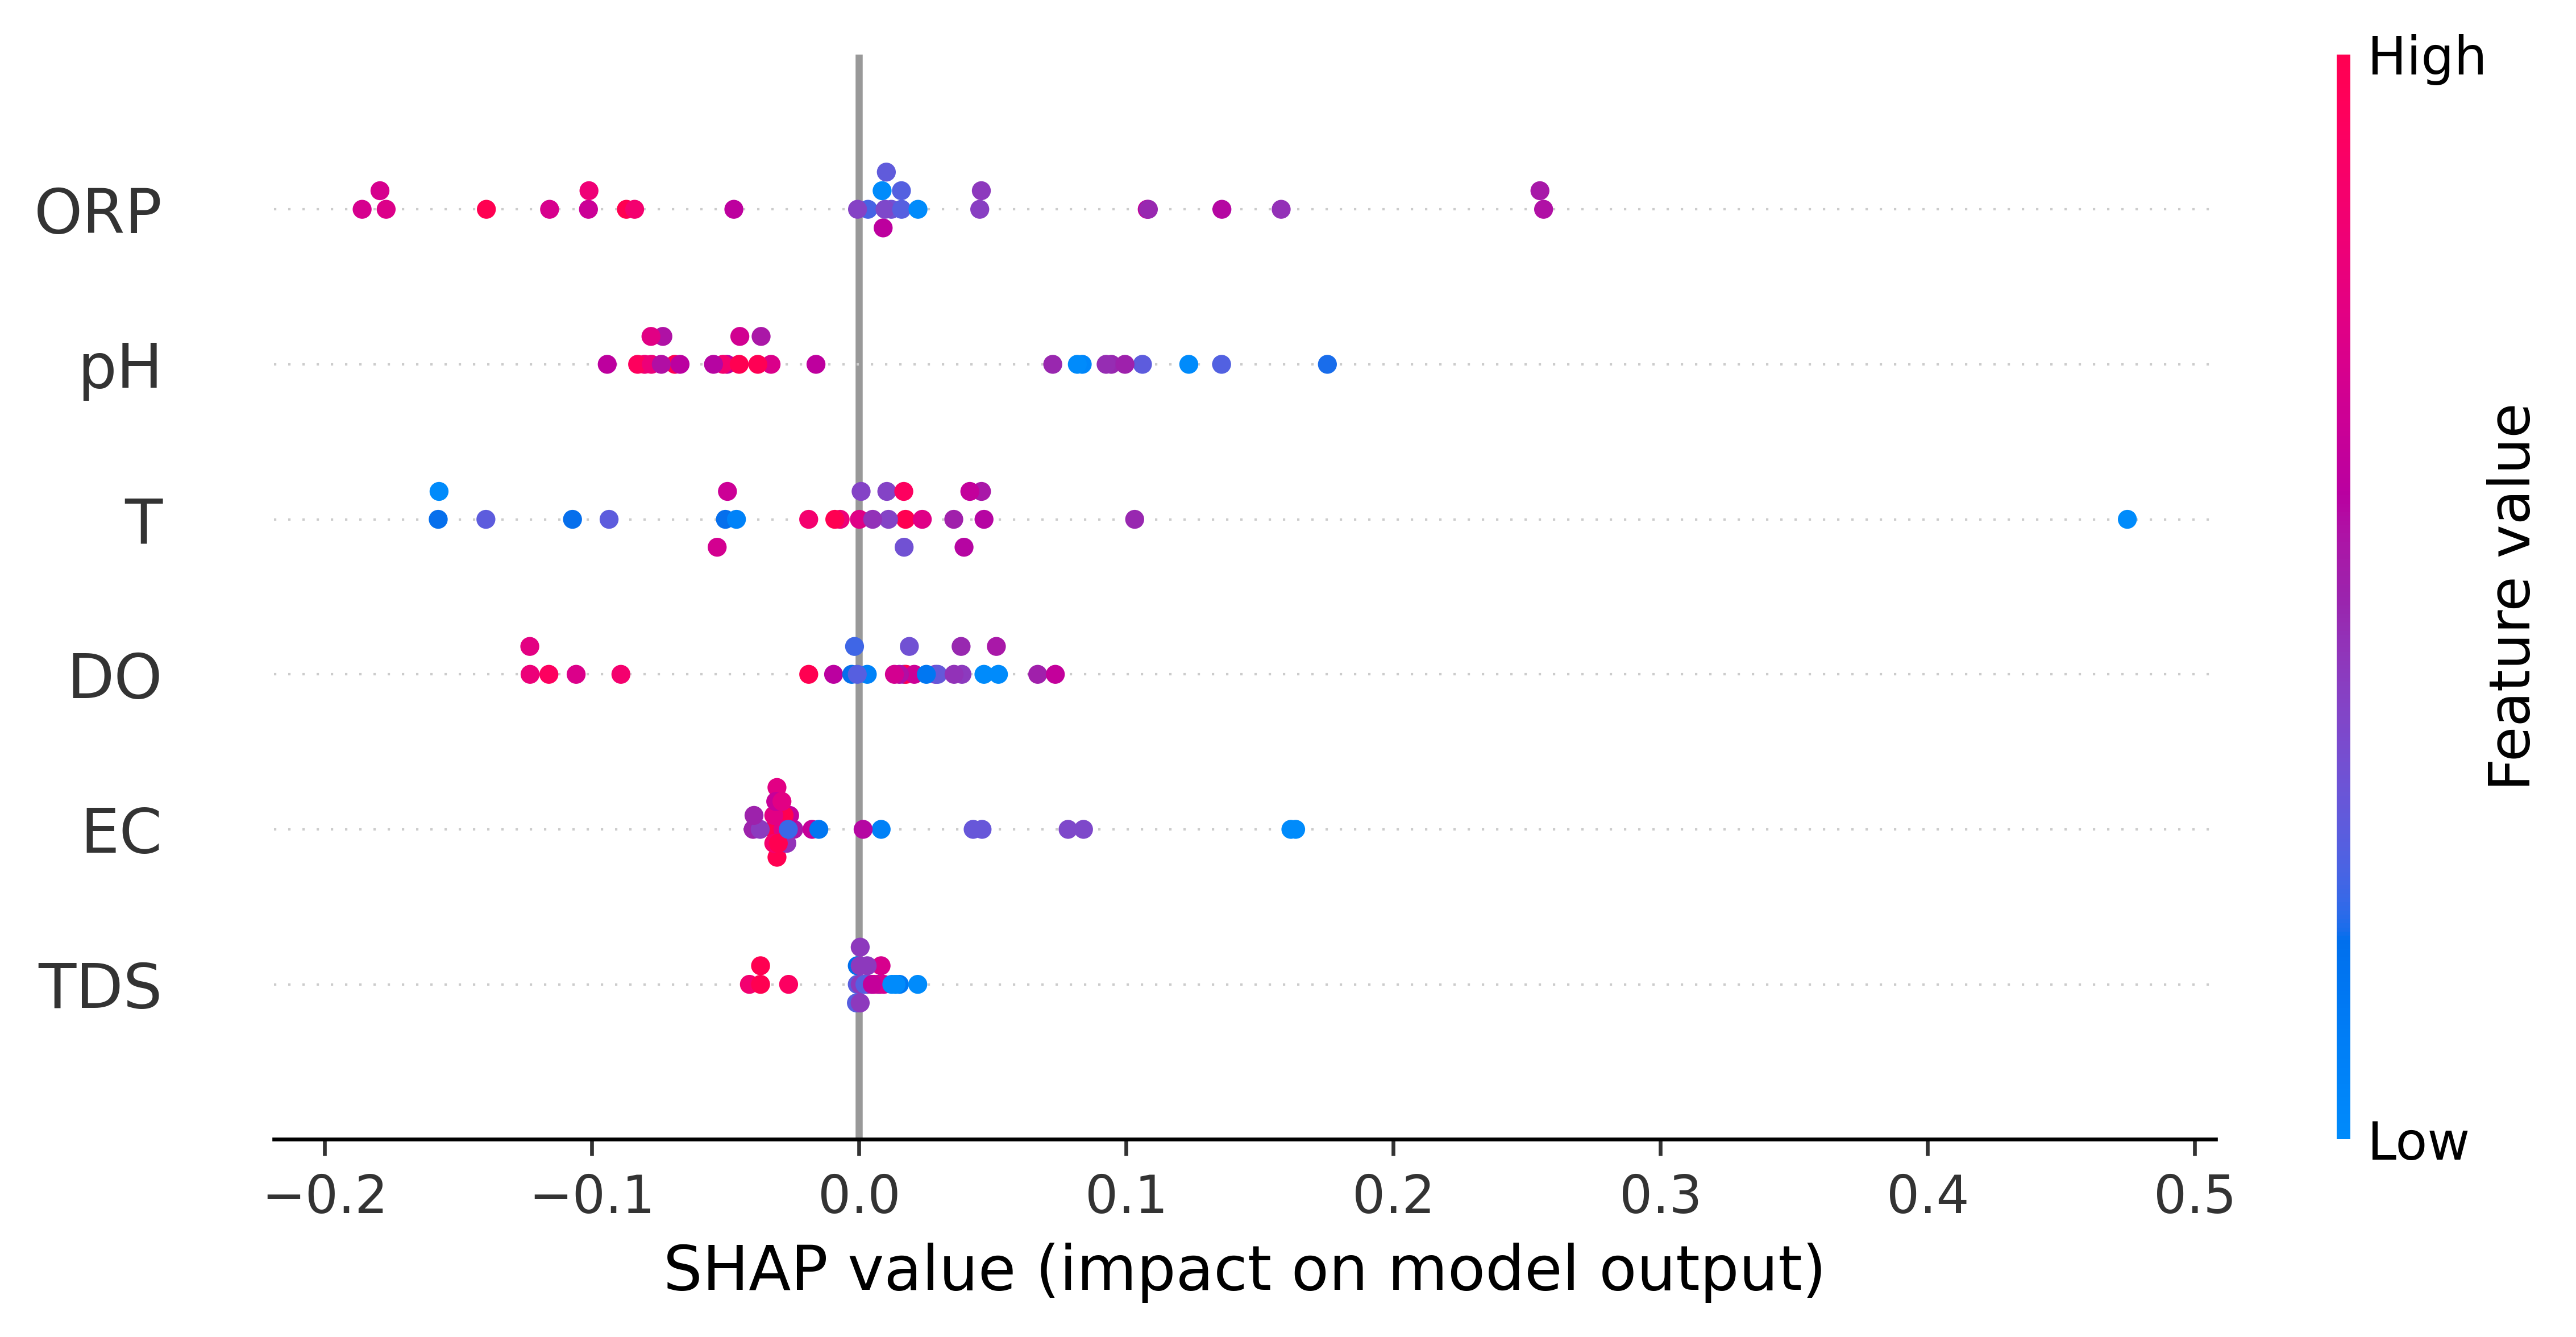

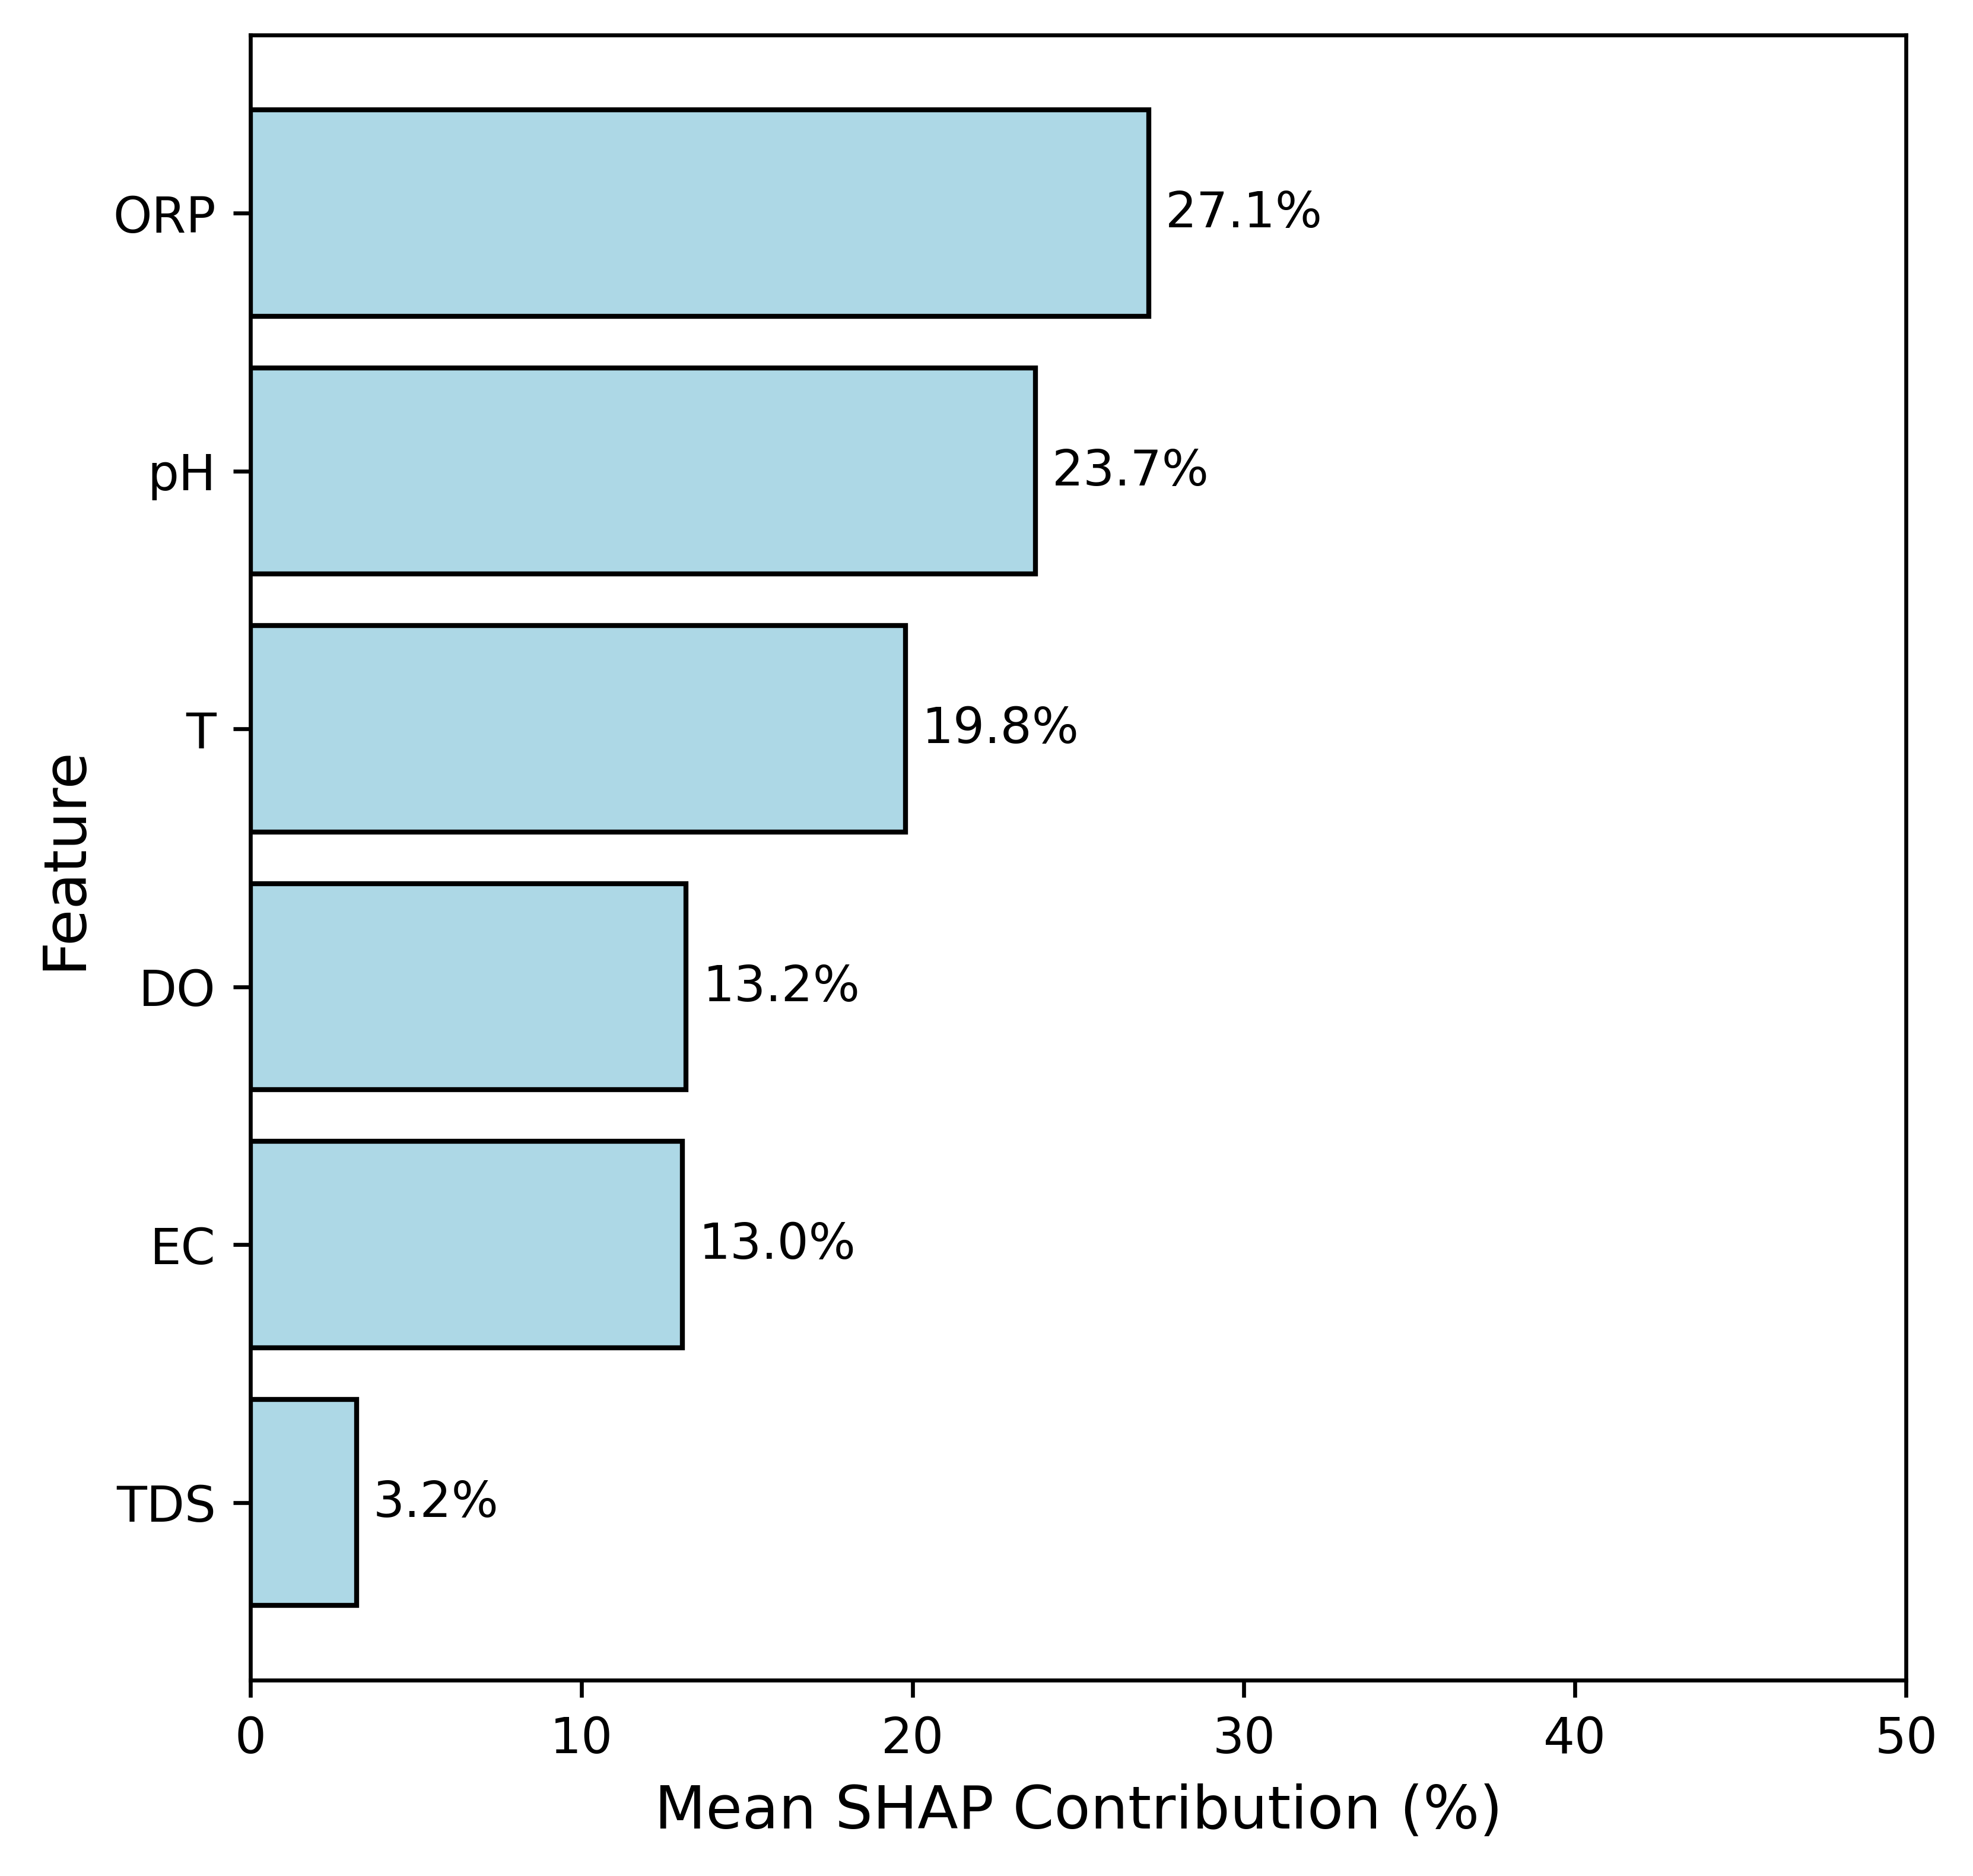

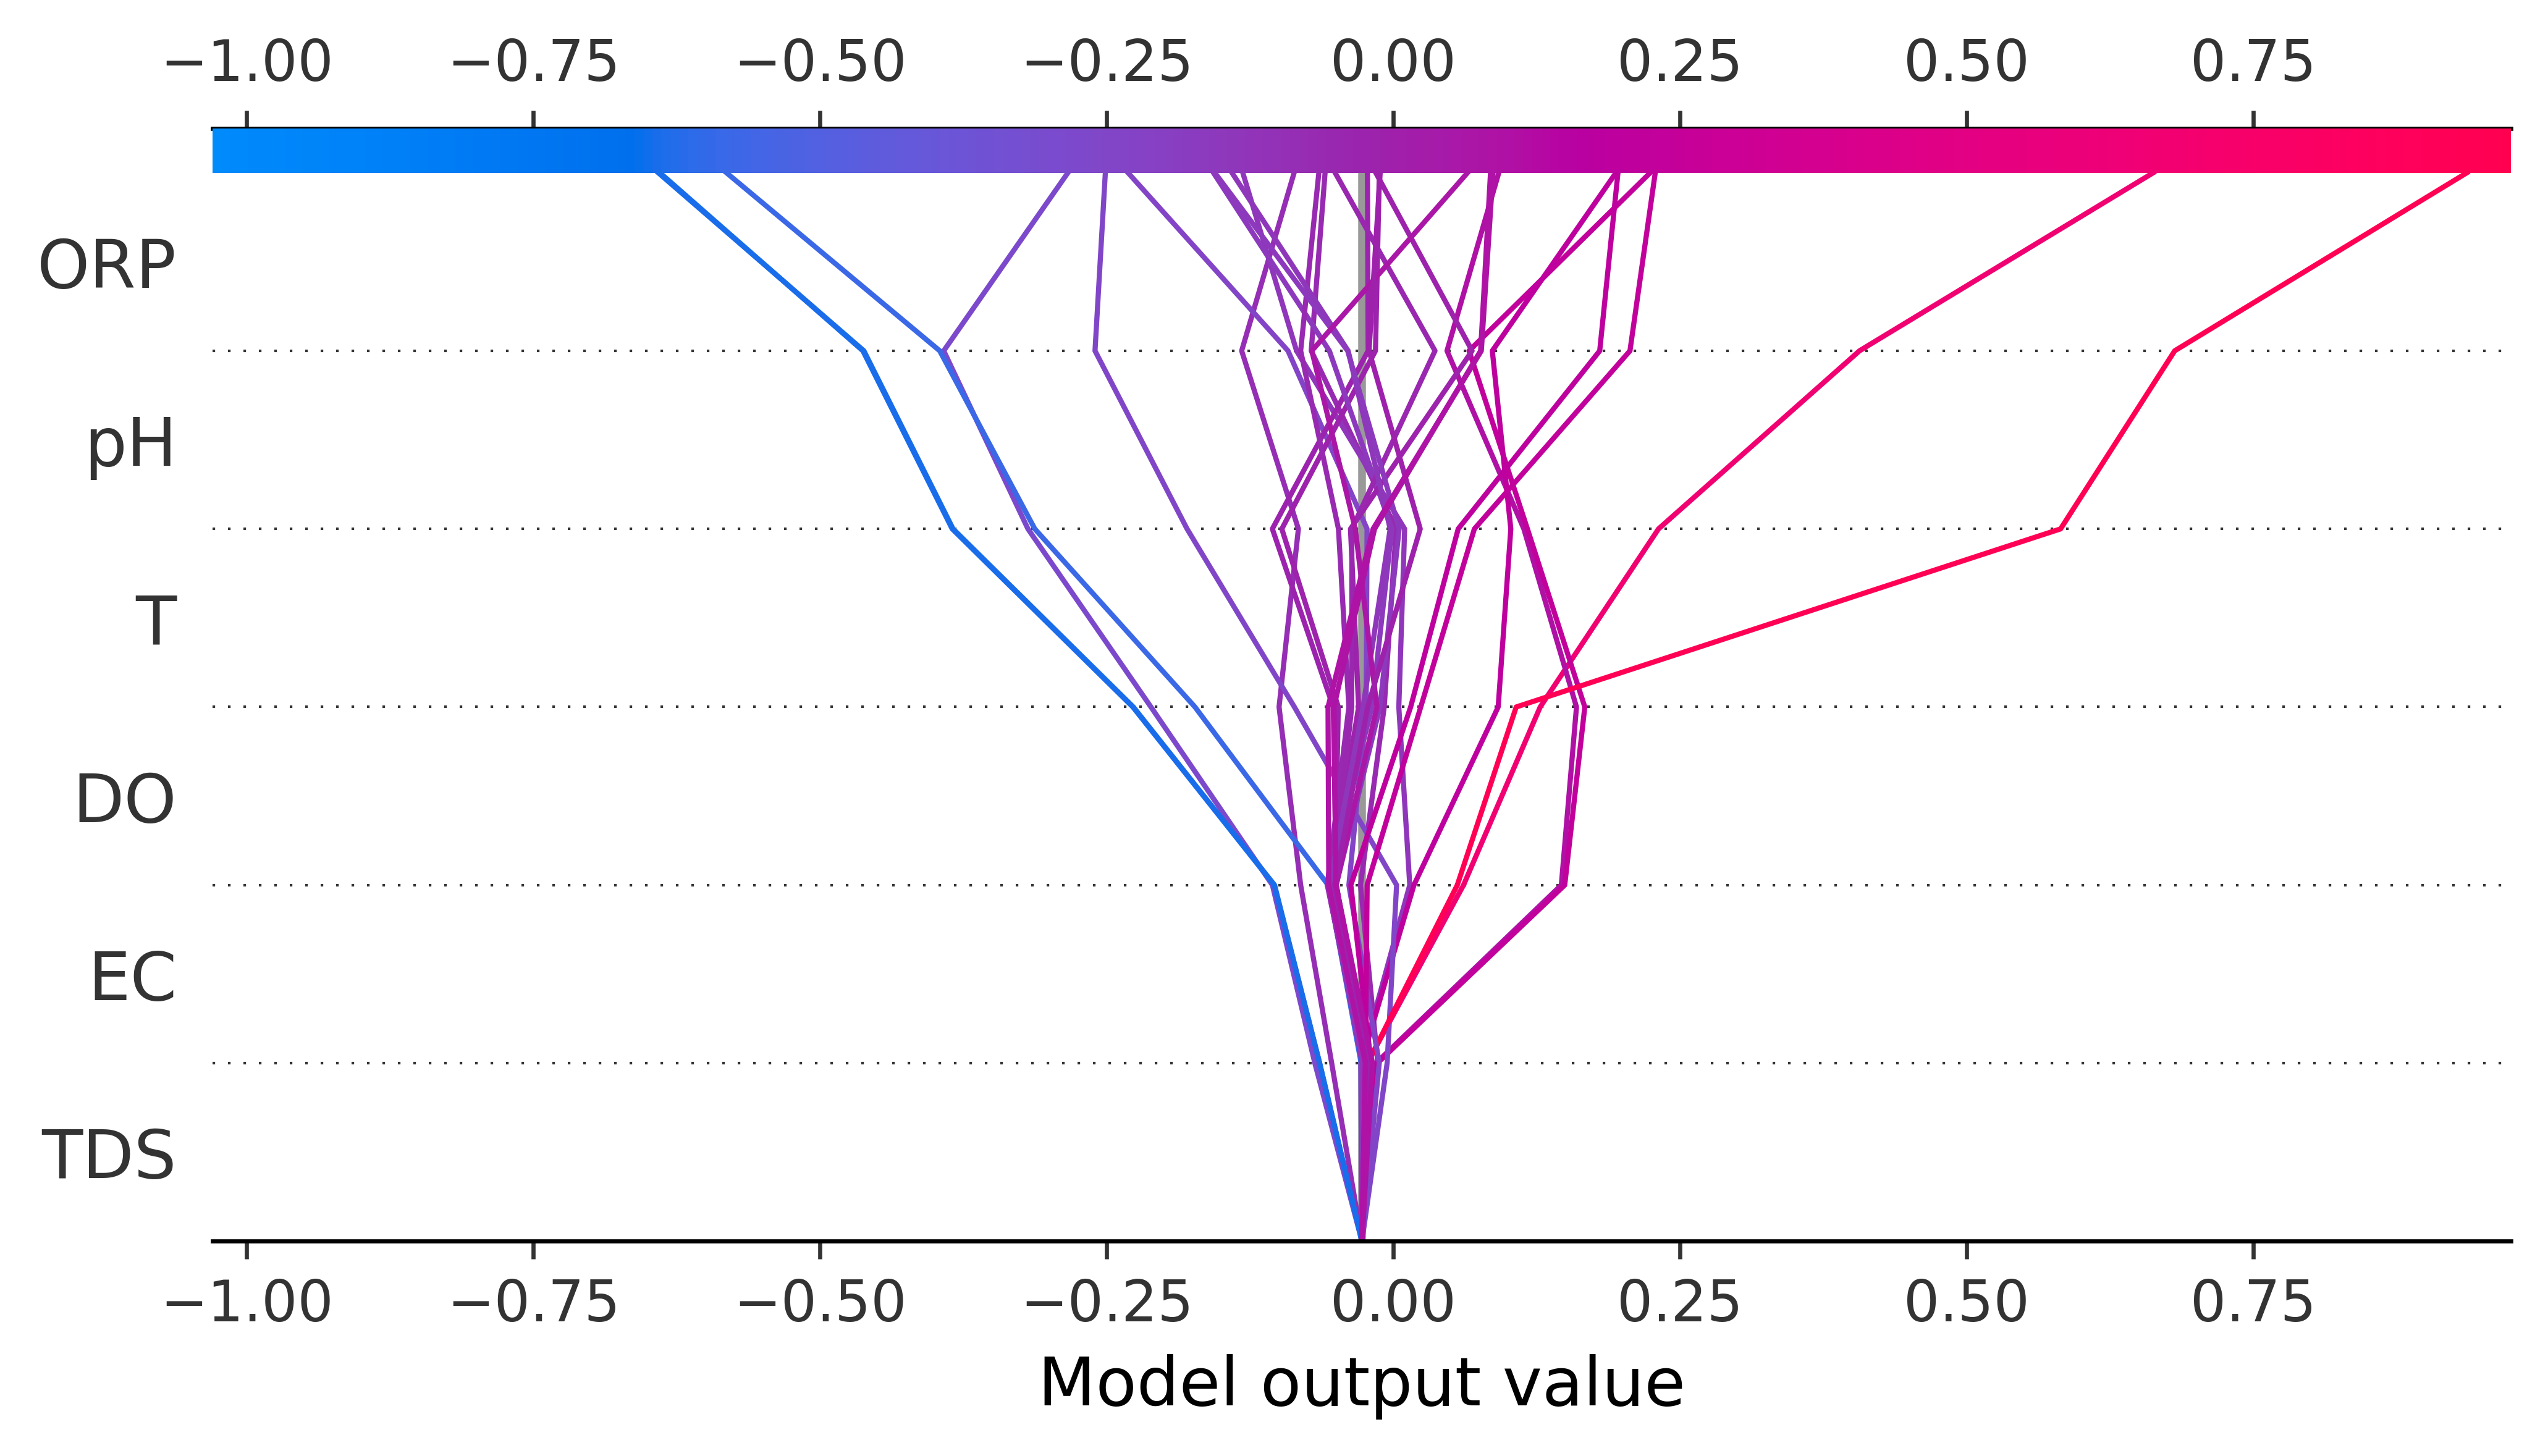

✅ SHAP results saved to 'shap_results_TP.xlsx'

Preview of SHAP contributions:
   Sample         T        DO        EC       ORP        pH       TDS
0       1  0.103163  0.066862  0.084004  0.256224  0.175297  0.004597
1       2  0.010390  0.020661 -0.015067  0.012075 -0.074040  0.013834
2       3 -0.045908  0.013219  0.161632  0.045173 -0.067011  0.012250
3       4  0.016856 -0.018849 -0.027053  0.045763 -0.049460 -0.026382
4       5 -0.107275 -0.105915 -0.037019  0.108282 -0.073442 -0.041061

Average SHAP Contributions (%):
  Feature  Mean SHAP (%)
5     TDS       3.195330
2      EC      13.039056
1      DO      13.157678
0       T      19.781573
4      pH      23.697546
3     ORP      27.128817


In [ ]:
####################################
### 2.2: XGBoost & SHAP analysis ###
####################################

# ================= Install Required Packages =================
!pip install shap xgboost openpyxl

# ================= Import Libraries =================
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from google.colab import files

plt.rcParams['font.family'] = ['sans-serif']  # font style
plt.rcParams['font.size'] = 6  # font size

# ================= Upload Dataset =================
data = pd.read_excel("LBanghu.xlsx")

# ================= Define Variable Groups =================
normal_vars = ['TP', 'pH', 'ORP']  # normally distributed variables
non_normal_vars = ['T', 'DO', 'EC', 'Chla', 'TN', 'TDS']  # non-normally distributed variables

# ================= Data Processing =================
quantile_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=len(data))  # convert to a normal distribution
data[non_normal_vars] = quantile_transformer.fit_transform(data[non_normal_vars])
scaler = StandardScaler()  # standardization
data[normal_vars + non_normal_vars] = scaler.fit_transform(data[normal_vars + non_normal_vars])

# ================= Split Dataset =================
X = data[['T', 'DO', 'EC', 'ORP', 'pH', 'TDS']]
y = data['TP']  # Target variable

# ================= XGBoost Parameter Tuning =================
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2
)
grid_search.fit(X, y)
best_xgb = grid_search.best_estimator_

# ================= SHAP Analysis =================
explainer = shap.Explainer(best_xgb, X)
shap_values = explainer(X)

shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_df.insert(0, 'Sample', range(1, len(shap_df) + 1))

shap_mean = shap_df.drop(columns=['Sample']).abs().mean()
shap_percent = (shap_mean / shap_mean.sum()) * 100
shap_summary_df = pd.DataFrame({'Feature': shap_percent.index, 'Mean SHAP (%)': shap_percent.values})

# ================= Export SHAP data =================
with pd.ExcelWriter('shap_results.xlsx', engine='openpyxl') as writer:
    shap_df.to_excel(writer, sheet_name='SHAP Contributions', index=False)
    shap_summary_df.to_excel(writer, sheet_name='Mean SHAP Values', index=False)

# ================= Visualizations =================
# Summary Plot
plt.figure(figsize=(6, 8), dpi=600)
shap.summary_plot(shap_values, X, show=False)
plt.savefig('shap_summary_plot.png', dpi=600, bbox_inches='tight')
plt.show()

# Bar Chart (contribution, %)
fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
shap_summary_df = shap_summary_df.sort_values(by="Mean SHAP (%)", ascending=True)
plt.barh(shap_summary_df['Feature'], shap_summary_df['Mean SHAP (%)'], color='lightblue', edgecolor='black')
plt.xlabel("Mean SHAP Contribution (%)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xlim(0, 50.0)
for index, value in enumerate(shap_summary_df["Mean SHAP (%)"]):
    plt.text(value + 0.5, index, f"{value:.1f}%", va='center', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('shap_bar_chart.png', dpi=600, bbox_inches='tight')
plt.show()

# SHAP Decision Plot
shap_values_numpy = shap_values.values
base_value = explainer.expected_value

fig, ax = plt.subplots(figsize=(6, 8), dpi=600)
shap.decision_plot(base_value, shap_values_numpy, X.columns, link='identity', show=False)
plt.savefig("shap_decision_plot.png", bbox_inches='tight', dpi=600)
plt.show()

print("✅ SHAP results saved to 'shap_results_TP.xlsx'")
print("\nPreview of SHAP contributions:")
print(shap_df.head())
print("\nAverage SHAP Contributions (%):")
print(shap_summary_df)

✅ Evaluation for TP (original scale) — R²: 0.9971, RMSE: 0.0009, MAE: 0.0004


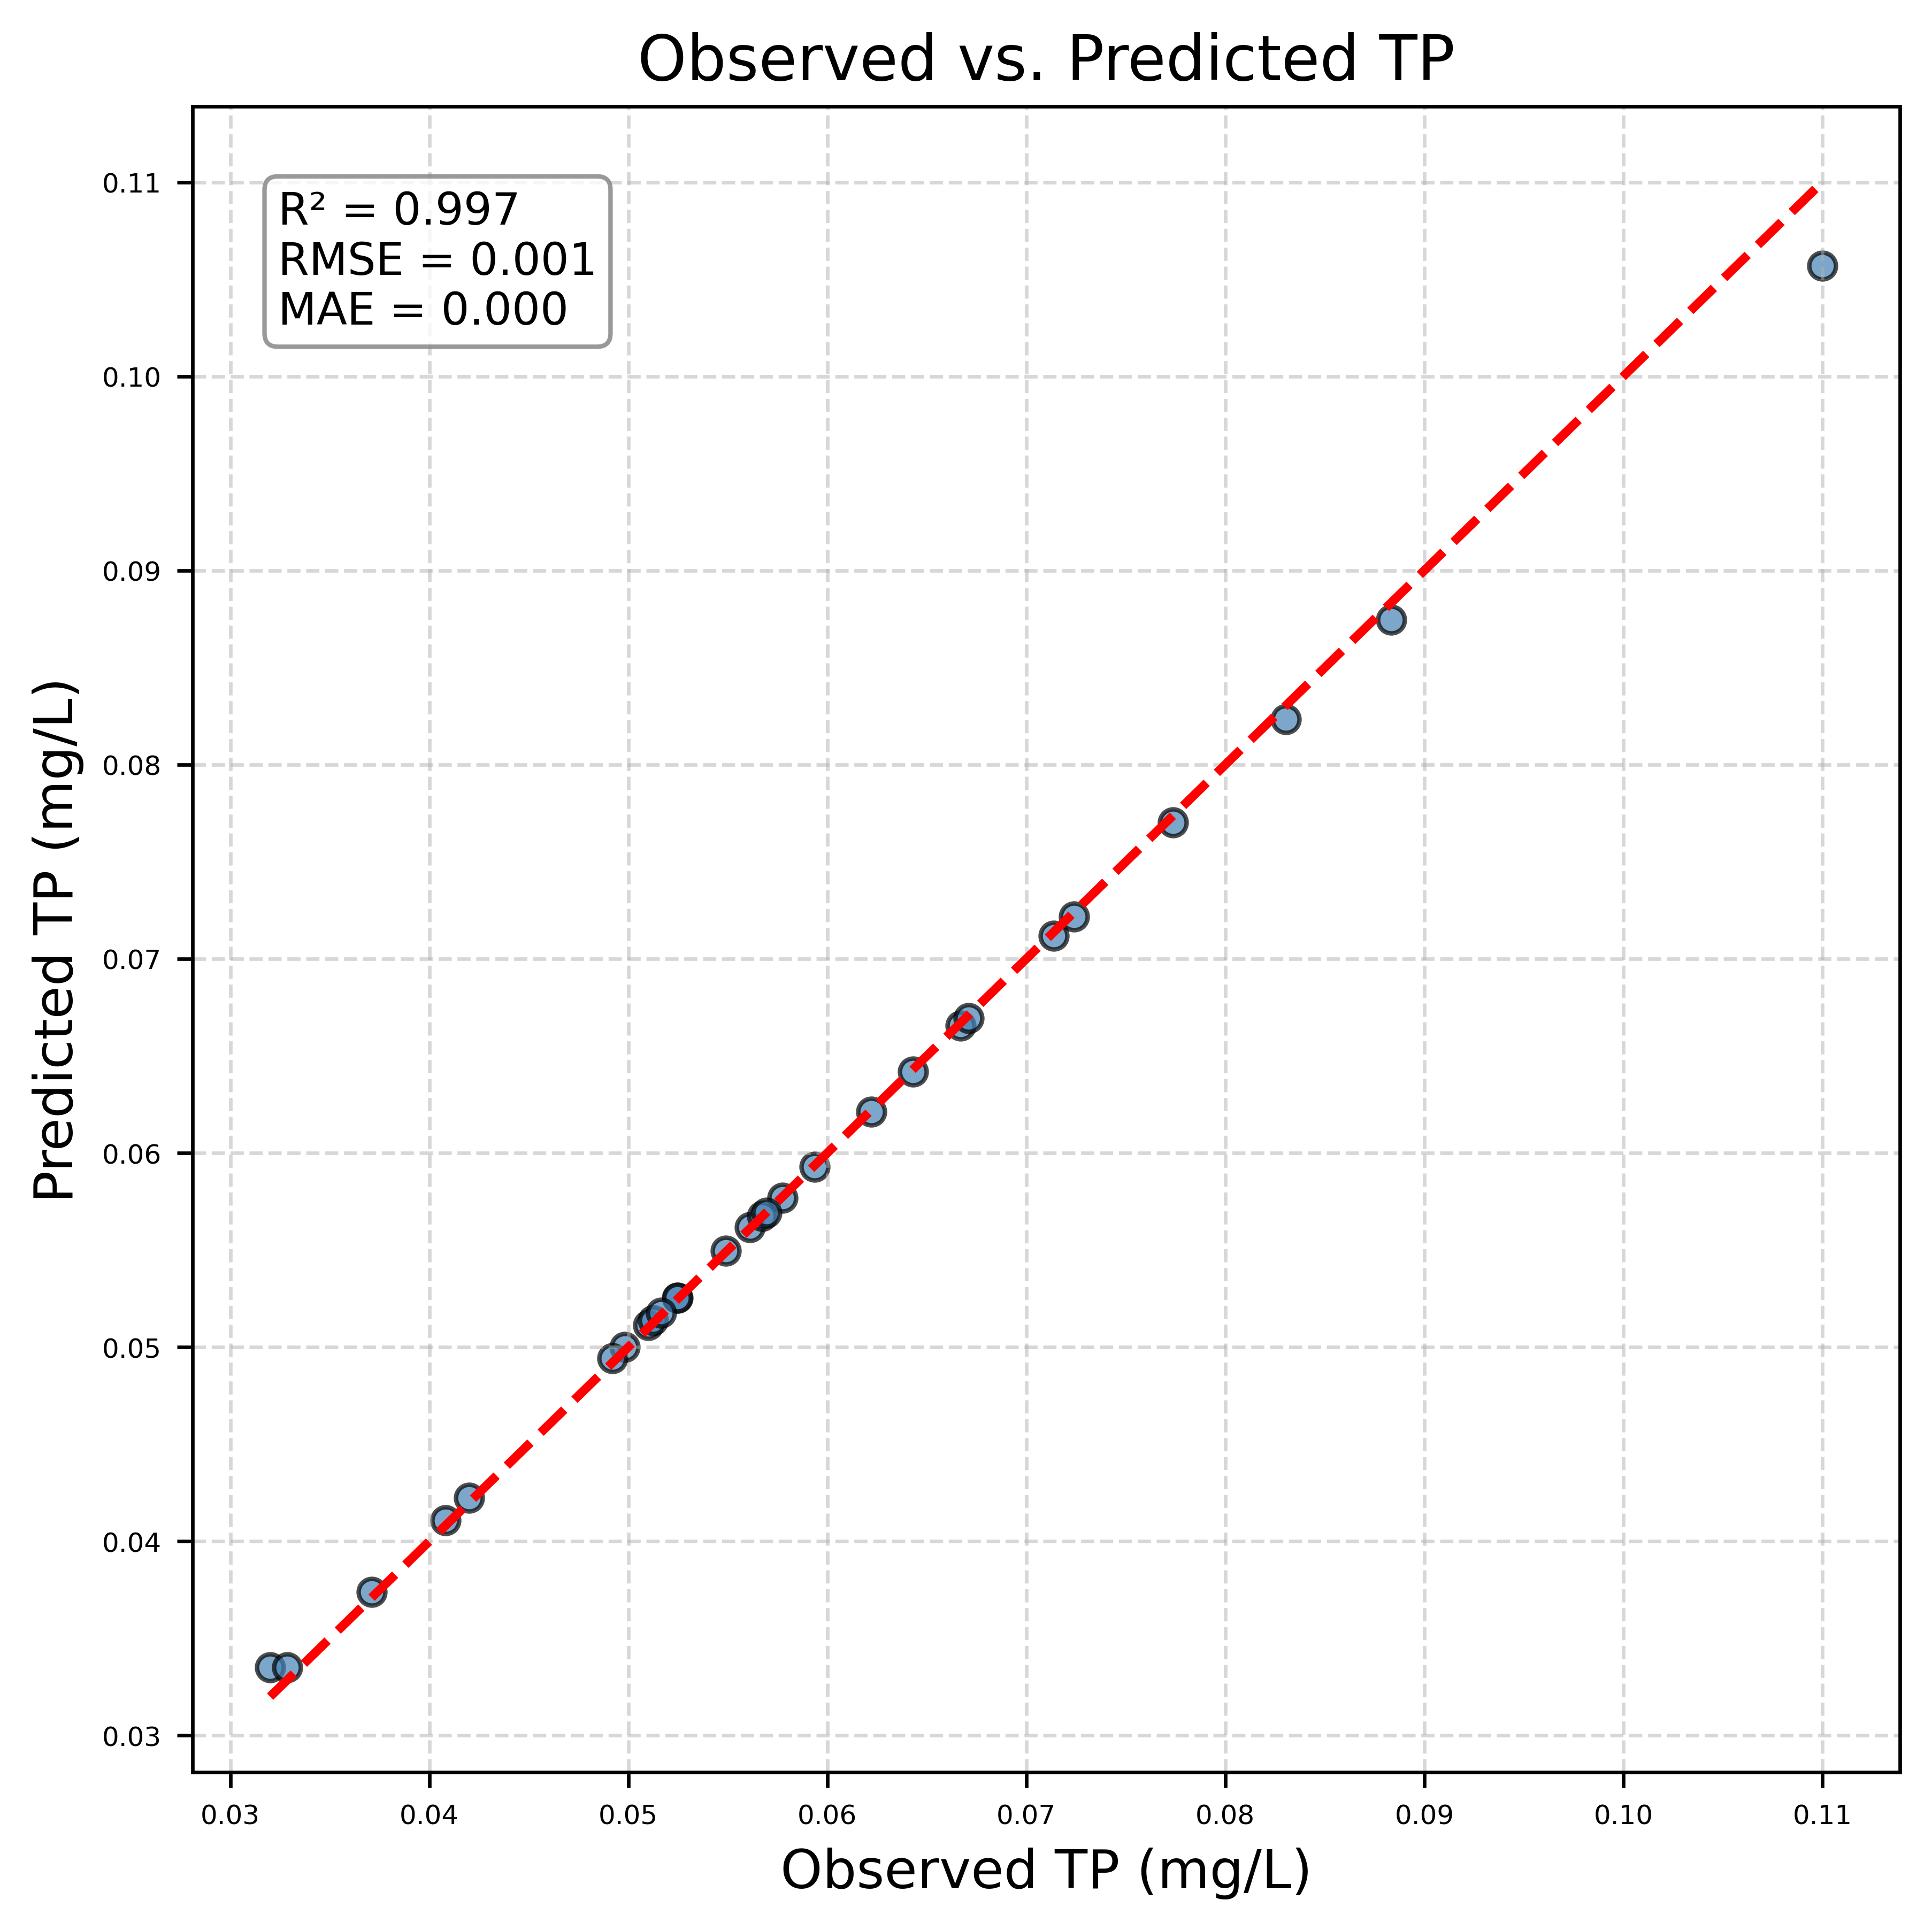

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Prediction results saved as TP_Predictions_TP.xlsx


In [ ]:
###############################
### 2.3: XGBoost Prediction ###
###############################

# ================= Import Required Libraries =================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from xgboost import XGBRegressor
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ================= Configuration Parameters =================
TARGET_VAR = "TP"  # Target variable
DROP_COLS = ['T', 'DO', 'EC', 'ORP', 'pH', 'TDS']  # Variables to drop from X (adjust as needed)

# ================= Upload Dataset =================
data = pd.read_excel("LBanghu.xlsx")

# ================= Store Original Target for Evaluation =================
original_target = data[TARGET_VAR].copy()

# ================= Define Normality =================
normal_vars = ["TP", "pH", "ORP"]
non_normal_vars = ["T", "DO", "EC", "Chla", "TN", "TDS"]

# ================= Apply Quantile Transformation to Non-Normal Vars =================
transformer = QuantileTransformer(output_distribution='uniform', random_state=42, n_quantiles=len(data))
data[non_normal_vars] = transformer.fit_transform(data[non_normal_vars])

# ================= Clean the Data =================
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# ================= Feature and Target Definition =================
X = data.drop(columns=DROP_COLS + [TARGET_VAR] if TARGET_VAR in DROP_COLS else DROP_COLS)
y = data[TARGET_VAR]

# ================= Standardize Features =================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ================= Train XGBoost Model =================
model = XGBRegressor(
    learning_rate=0.05,
    max_depth=3,
    n_estimators=100,
    reg_lambda=1,
    random_state=42
)
model.fit(X_scaled, y)

# ================= Make Prediction =================
y_pred = model.predict(X_scaled)

# ================= Inverse Transform If Target Was Non-Normal =================
if TARGET_VAR in non_normal_vars:
    temp_df = data[non_normal_vars].copy()
    temp_df[TARGET_VAR] = y
    temp_df_pred = data[non_normal_vars].copy()
    temp_df_pred[TARGET_VAR] = y_pred

    y_original = transformer.inverse_transform(temp_df)[:, non_normal_vars.index(TARGET_VAR)]
    y_pred_original = transformer.inverse_transform(temp_df_pred)[:, non_normal_vars.index(TARGET_VAR)]
else:
    y_original = y
    y_pred_original = y_pred

# ================= Evaluation Metrics =================
r2 = r2_score(y_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_original, y_pred_original))
mae = mean_absolute_error(y_original, y_pred_original)

print(f"✅ Evaluation for {TARGET_VAR} (original scale) — R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# ================= Visualization =================
plt.figure(figsize=(6, 6), dpi=600)
plt.scatter(y_original, y_pred_original, alpha=0.7, color='steelblue', edgecolor='k')
plt.plot([y_original.min(), y_original.max()],
         [y_original.min(), y_original.max()],
         'r--', lw=2)

plt.xlabel(f'Observed {TARGET_VAR} (mg/L)', fontsize=12)
plt.ylabel(f'Predicted {TARGET_VAR} (mg/L)', fontsize=12)
plt.title(f'Observed vs. Predicted {TARGET_VAR}', fontsize=14)

# Text box for metrics
textstr = f'R² = {r2:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='left',
         bbox=props, fontsize=10)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f"{TARGET_VAR}_Observed_vs_Predicted.tiff", dpi=600, format='tiff')
plt.show()

# ================= Save and Export Results =================
results_df = pd.DataFrame({
    f'Actual_{TARGET_VAR}_Original': y_original,
    f'Predicted_{TARGET_VAR}_Original': y_pred_original
})
output_filename = f"{TARGET_VAR}_Predictions_TP.xlsx"
results_df.to_excel(output_filename, index=False)
files.download(output_filename)
print(f"✅ Prediction results saved as {output_filename}")

In [ ]:
##############################################
### Section 3: MLMs&SHAP analysis for Chla ###
##############################################

#######################################
### 3.1: Model Training & Selection ###
#######################################

# ================= Import Required Libraries =================
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ================= Upload Dataset =================
data = pd.read_excel("LBanghu.xlsx")

# ================= Normality Tested Variables in this study =================
normal_vars = ["TP", "pH", "ORP"]  # Normally distributed variables
non_normal_vars = ["T", "DO", "EC", "Chla", "TN", "TDS"]  # Non-normally distributed variables

#======= Handling Non-Normally Distributed Variables (Quantile Transformation) ========
transformer = QuantileTransformer(output_distribution='uniform', random_state=42, n_quantiles=len(data))
data[non_normal_vars] = transformer.fit_transform(data[non_normal_vars])
print("✅ Non-normally distributed variables are transformed. Normally distributed variables remain unchanged.")

# ================= Handling Missing and Infinite Values =================
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# ================= Split Dataset =================
X = data.drop(columns=['T', 'DO', 'EC', 'ORP', 'pH', 'TDS'])  # Features
y = data['Chla']  # Target variable

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ================= Hyperparameter Grids =================
param_grid = {
    "SVR": {
        "kernel": ['rbf'],
        "C": [0.1, 1, 5, 10],
        "epsilon": [0.01, 0.05, 0.1],
        "gamma": ['scale', 'auto']
    },
    "Random Forest": {
        "n_estimators": [100, 200, 500],
        "max_depth": [None, 4, 6, 8],
        "min_samples_split": [2, 4, 6]
    },
    "XGBoost": {
        "n_estimators": [100, 200, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "reg_lambda": [1, 2, 5]
    },
    "KNN": {
        "n_neighbors": [3, 5, 10],
        "weights": ['uniform', 'distance']
    }
}

# ================= Model Training =================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_models = {}
results = []

for name, model in [
    ("SVR", SVR()),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42)),
    ("KNN", KNeighborsRegressor())
]:
    print(f"🔍 Optimizing {name}...")
    grid_search = GridSearchCV(model, param_grid[name], cv=kf, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Evaluation Metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    cv_r2 = cross_val_score(best_model, X_scaled, y, cv=kf, scoring='r2').mean()

    results.append([name, train_mse, test_mse, train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2, cv_r2])

    print(f"✅ Best Parameters: {grid_search.best_params_}")
    print(f"✅ R² (Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}, CV R2: {cv_r2:.4f})\n")

# ================= Export Results =================
results_df = pd.DataFrame(results, columns=["Model", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", "Train MAE", "Test MAE", "Train R²", "Test R²", "CV R²"])

results_df.to_excel("final_model_results_Chla.xlsx", index=False)
files.download("final_model_results_Chla.xlsx")
print("✅ Final results saved to 'final_model_results_Chla.xlsx'")

✅ Non-normally distributed variables are transformed. Normally distributed variables remain unchanged.
🔍 Optimizing SVR...
✅ Best Parameters: {'C': 5, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
✅ R² (Train R2: 0.9988, Test R2: 0.7592, CV R2: 0.9222)

🔍 Optimizing Random Forest...
✅ Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
✅ R² (Train R2: 0.9946, Test R2: 0.9627, CV R2: 0.9742)

🔍 Optimizing XGBoost...
✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 1}
✅ R² (Train R2: 0.9984, Test R2: 0.9699, CV R2: 0.9593)

🔍 Optimizing KNN...
✅ Best Parameters: {'n_neighbors': 3, 'weights': 'distance'}
✅ R² (Train R2: 1.0000, Test R2: 0.5776, CV R2: 0.8232)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Final results saved to 'final_model_results_Chla.xlsx'


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


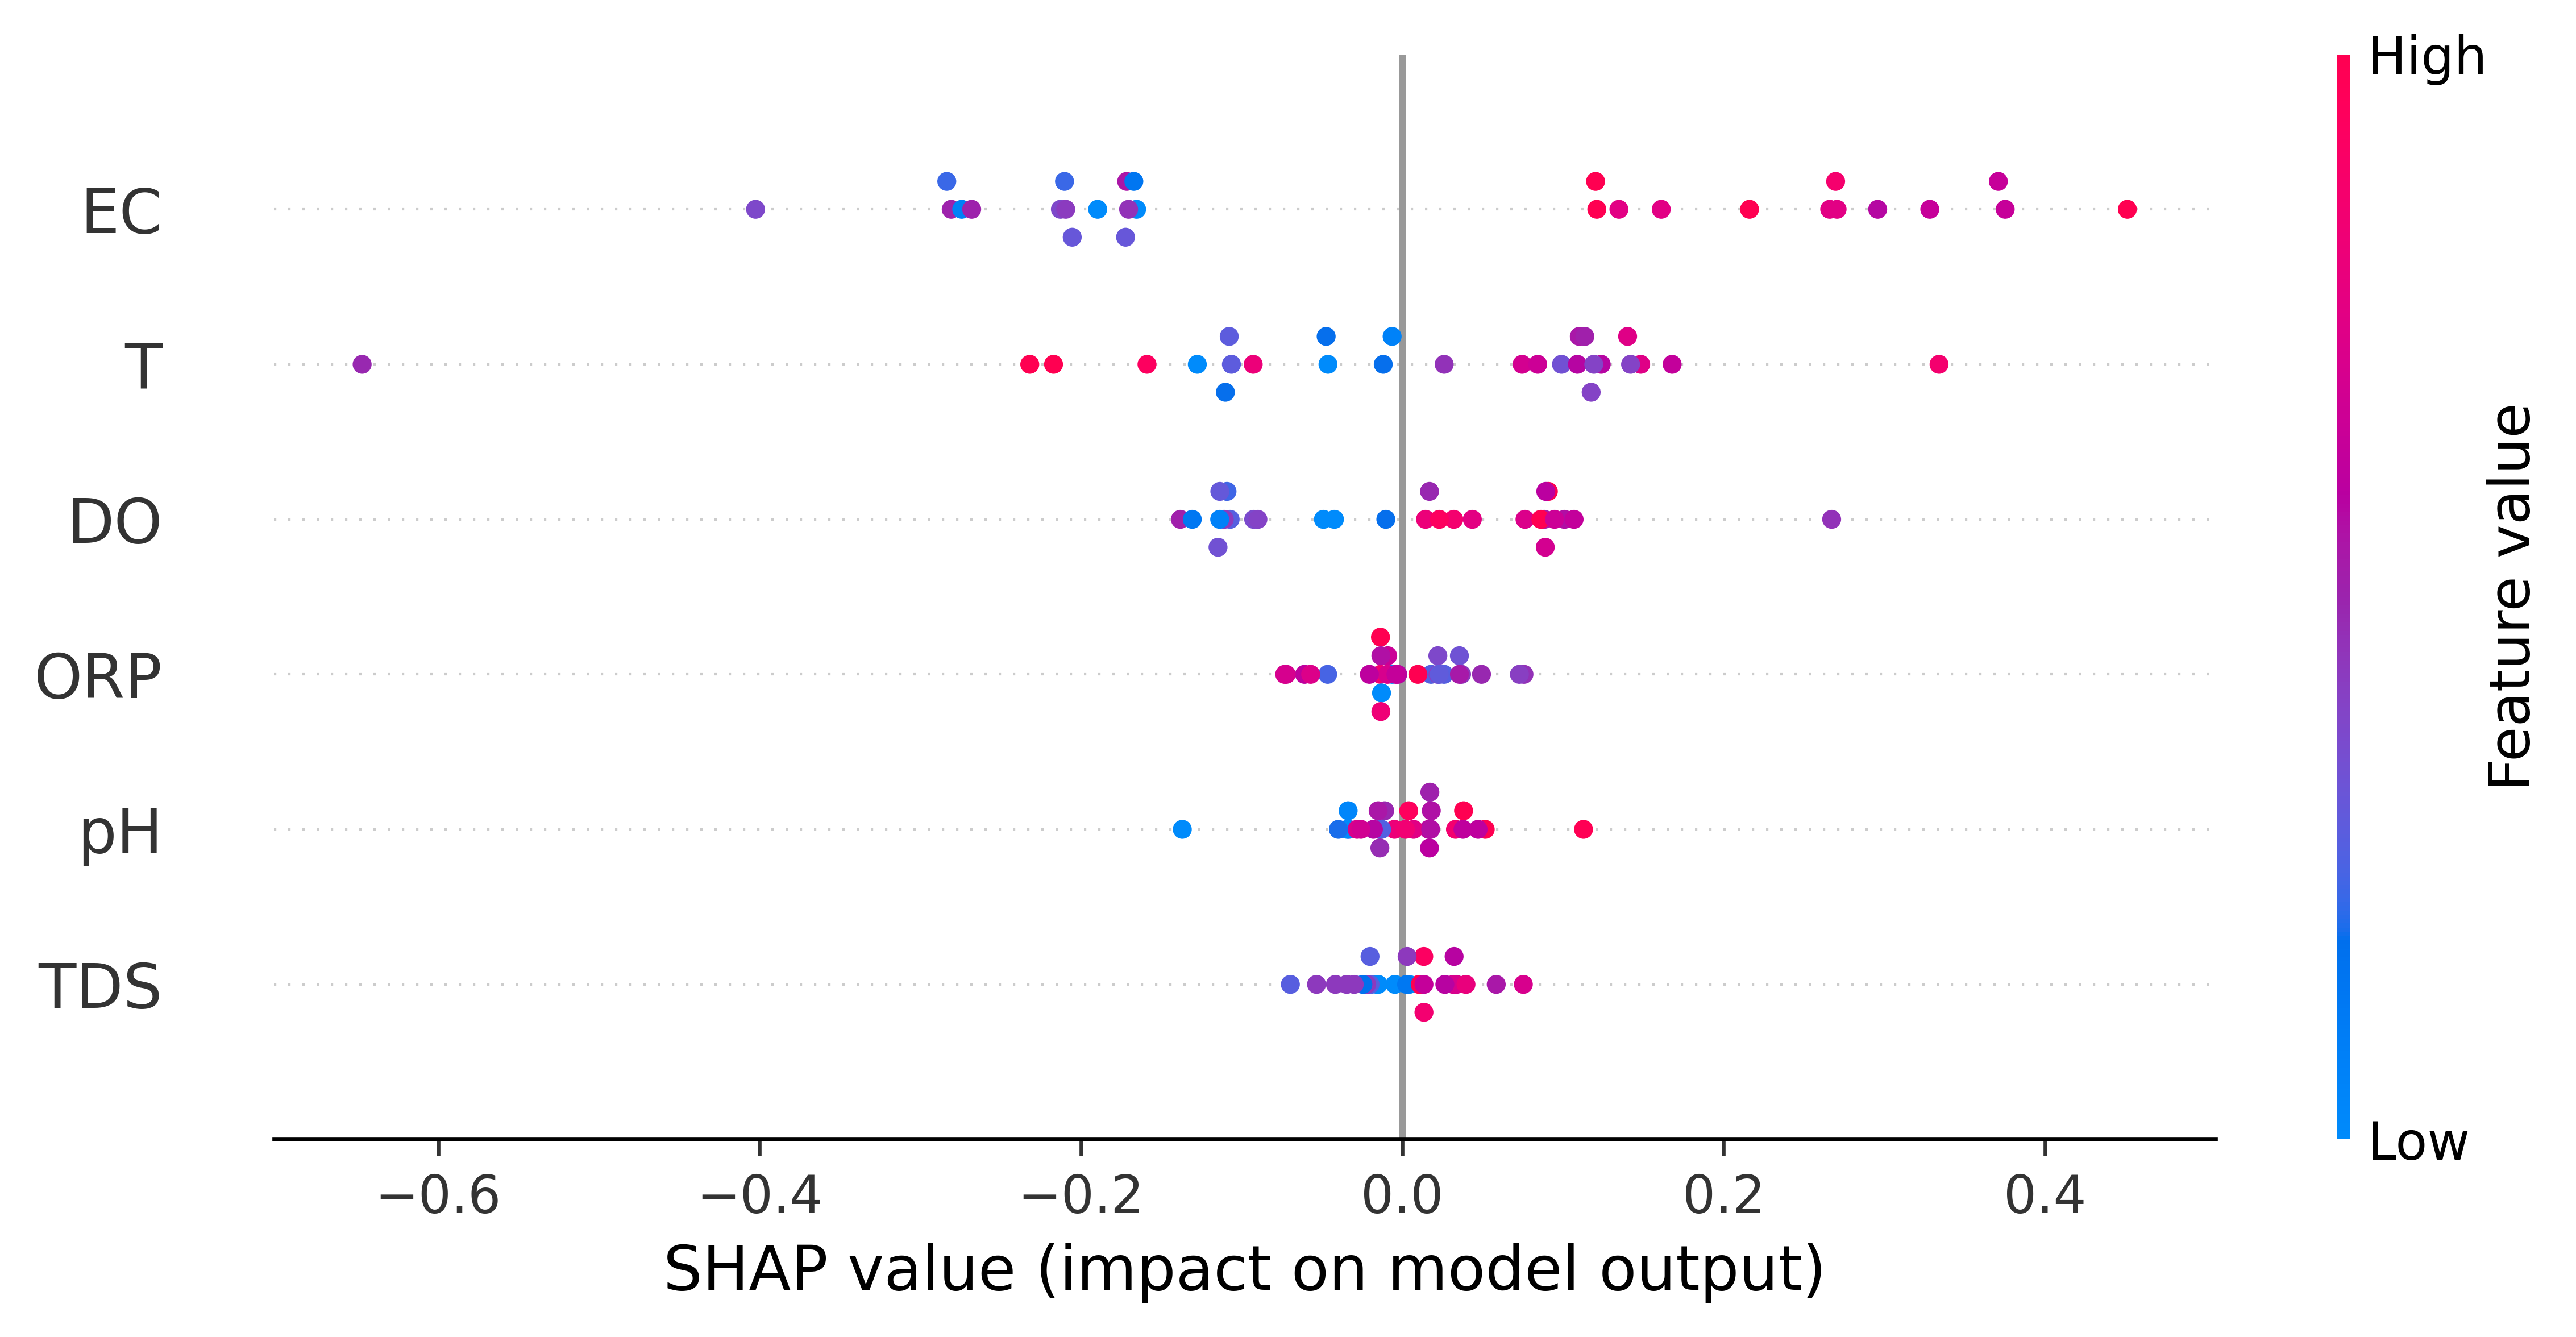

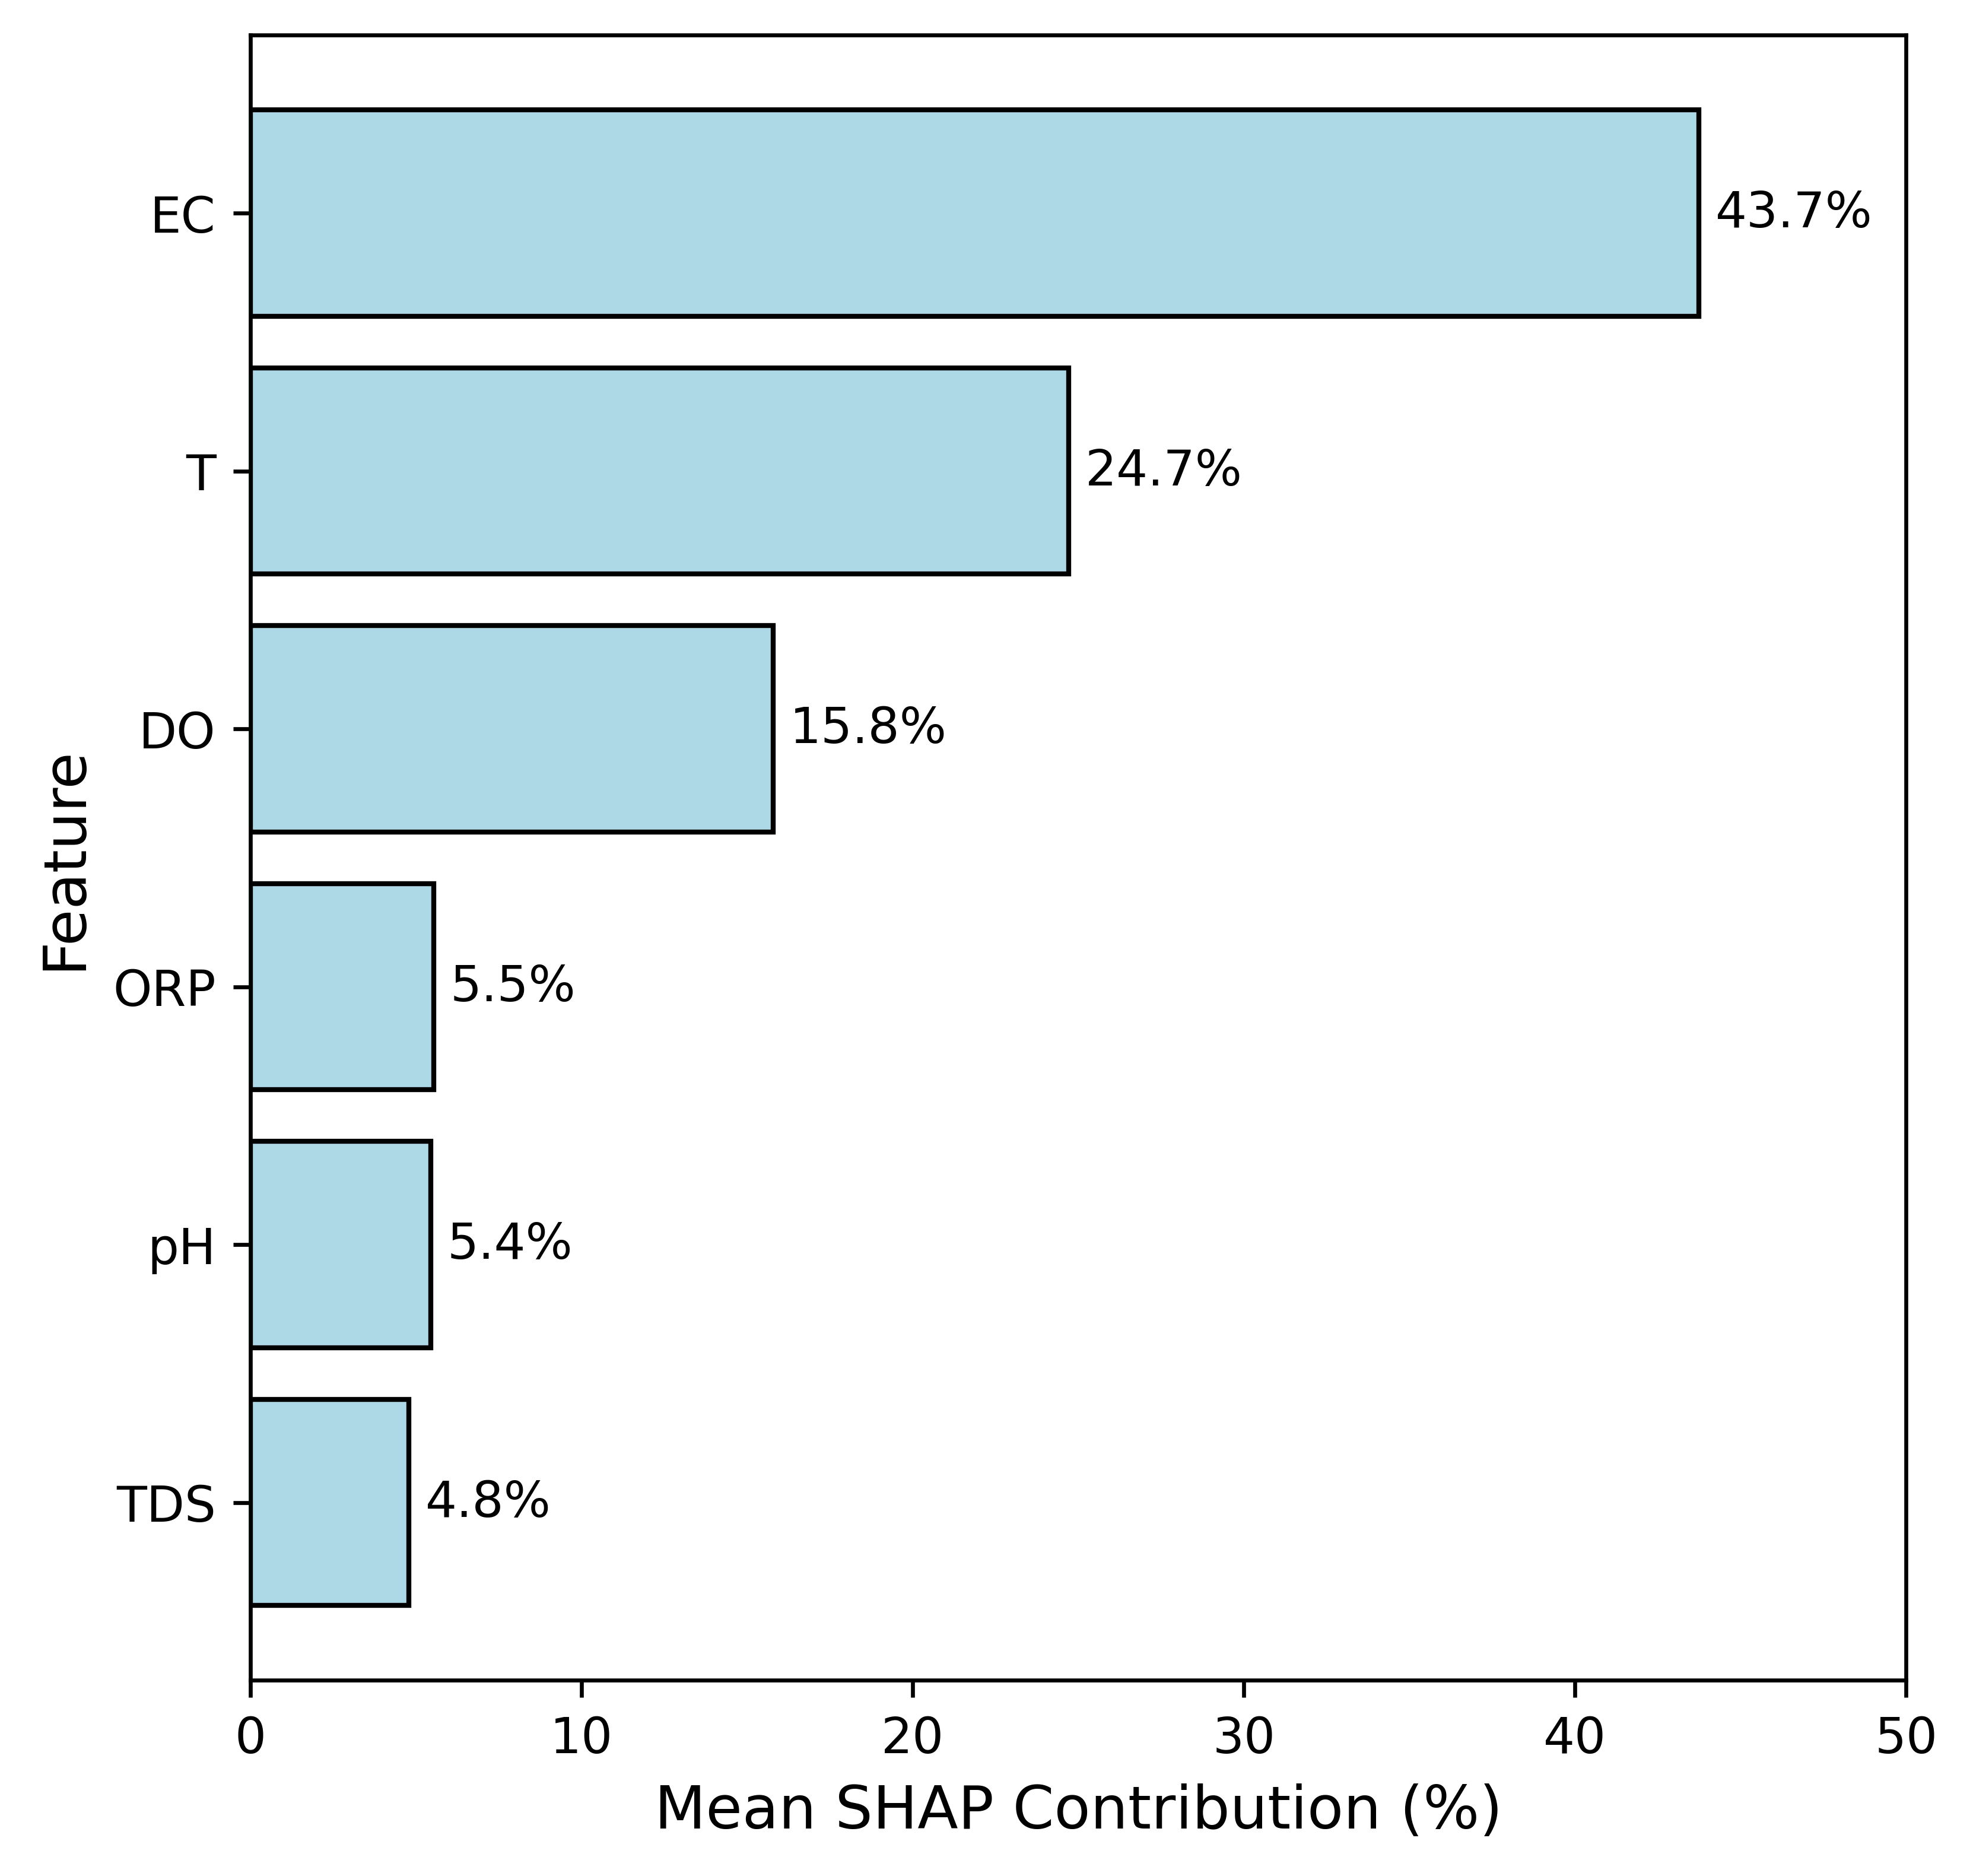

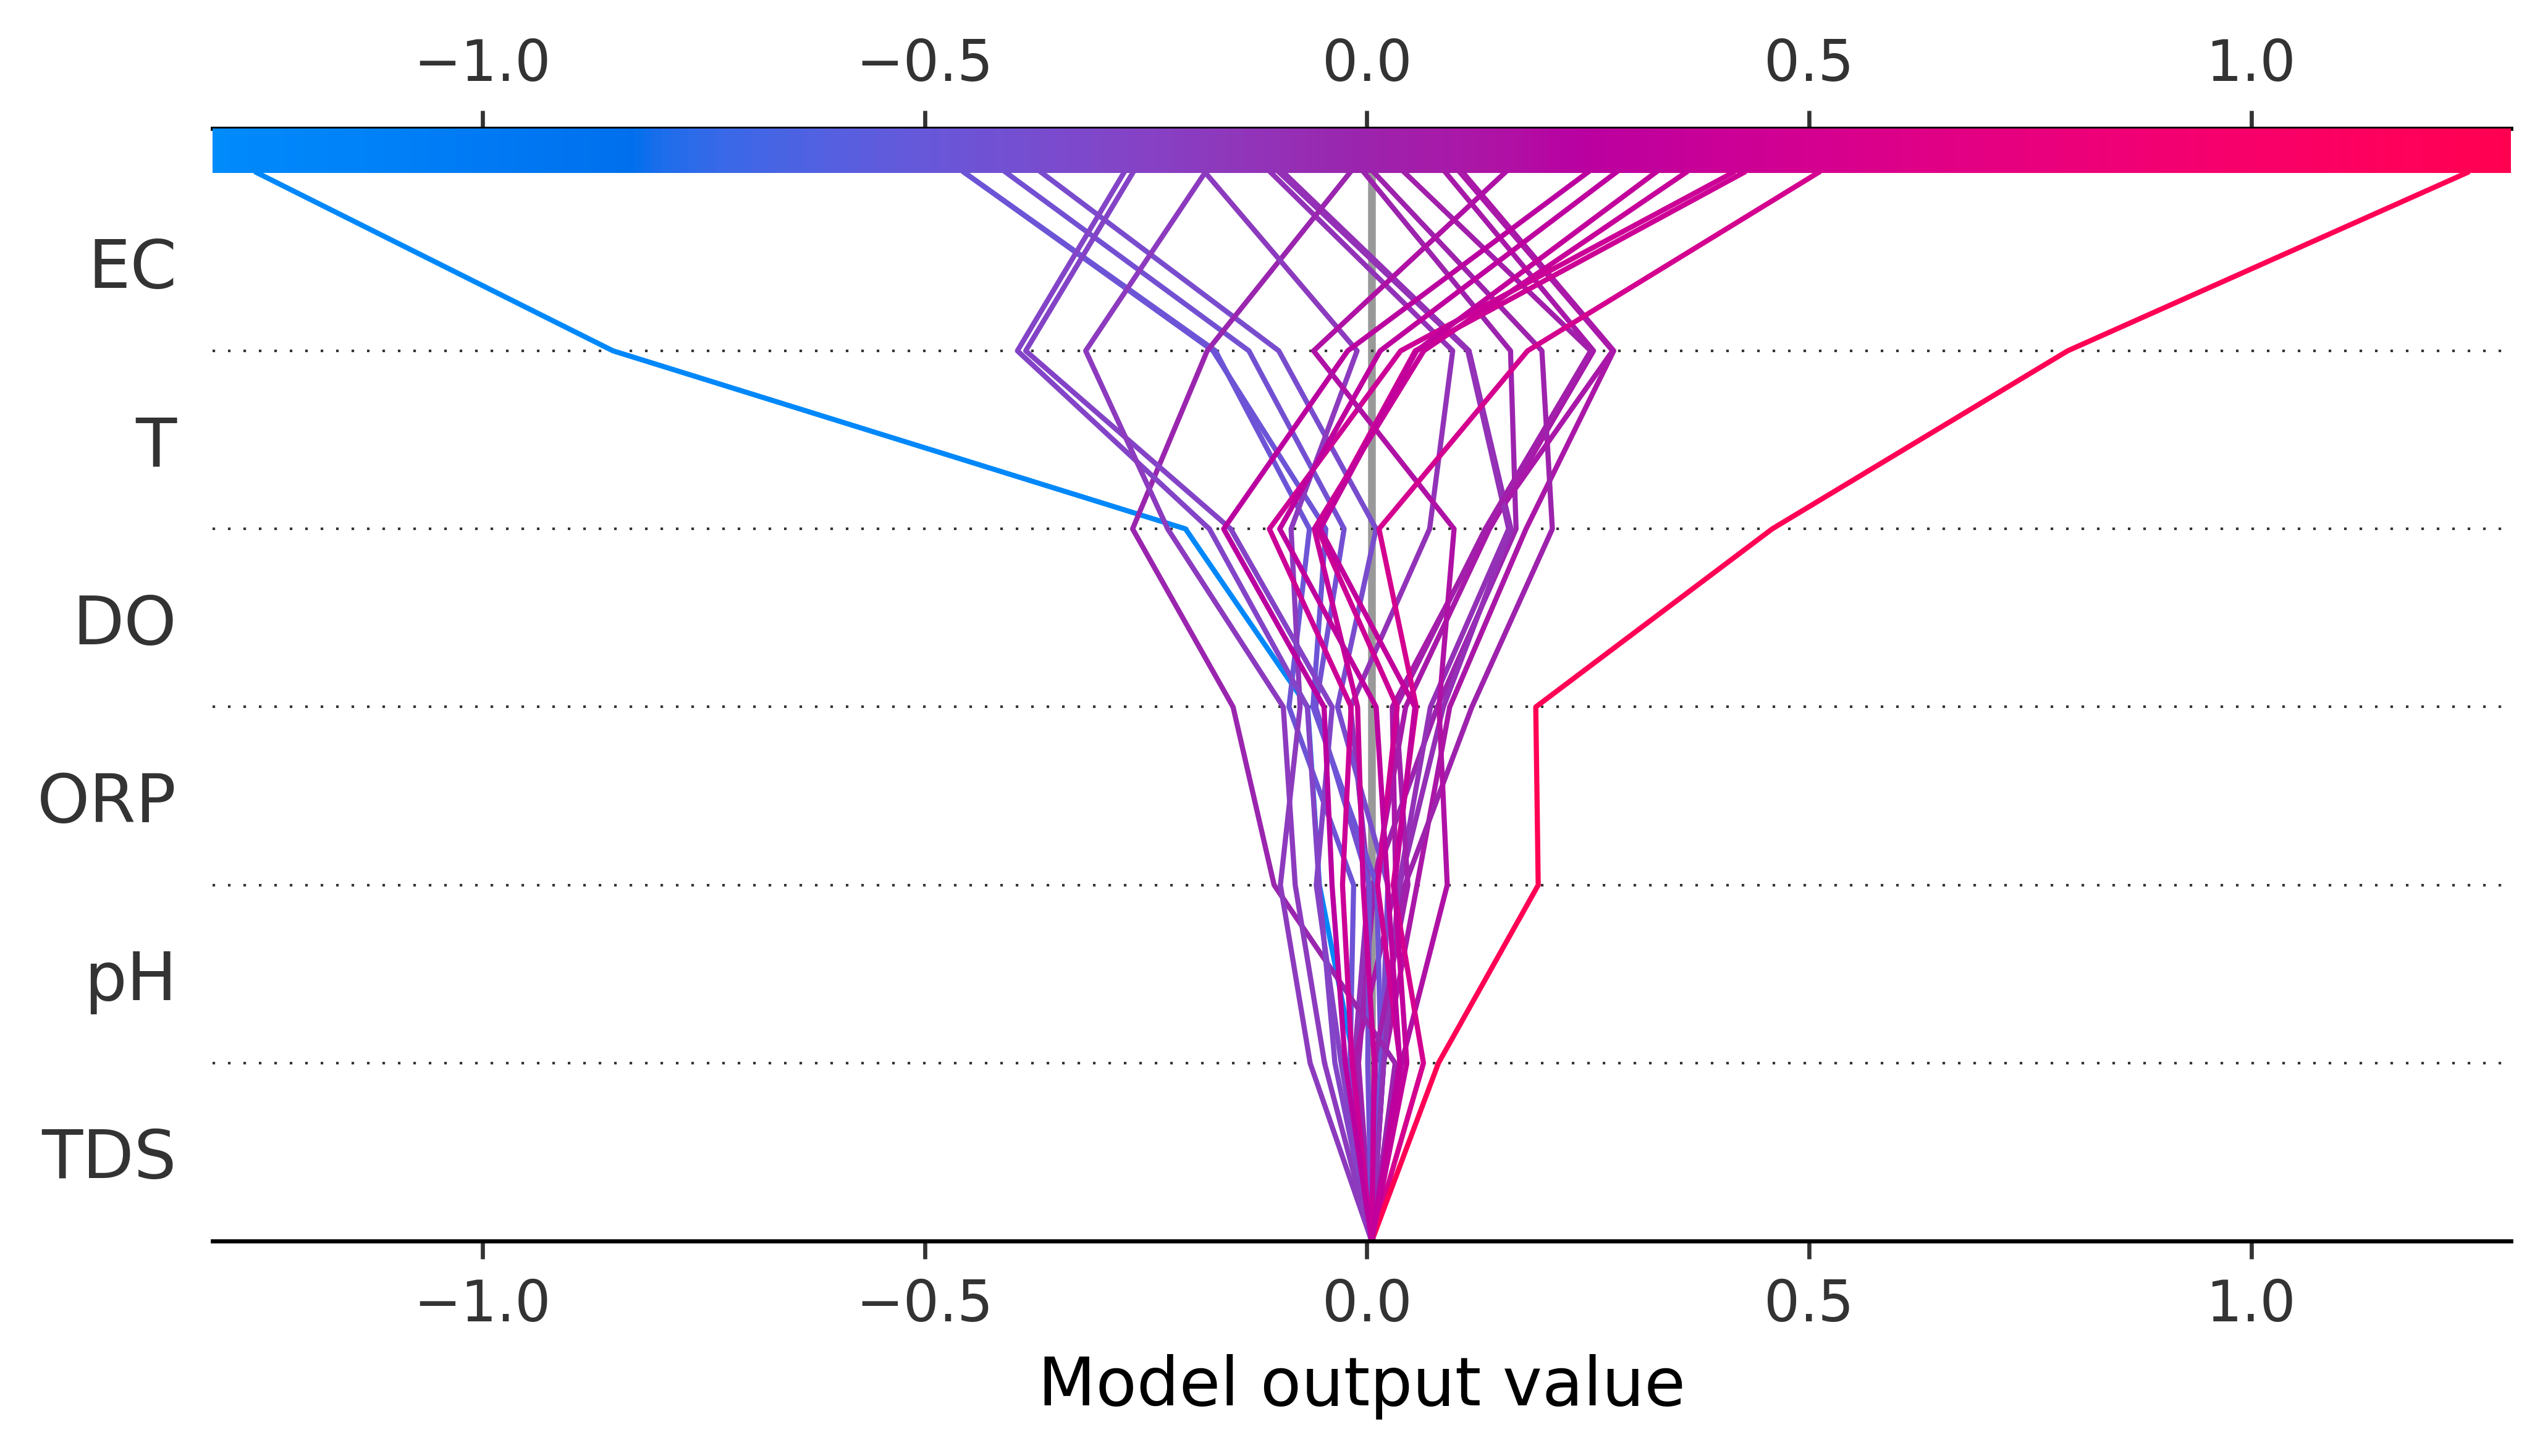

✅ SHAP results saved to 'shap_results_Chla.xlsx'

Preview of SHAP contributions:
   Sample         T        DO        EC       ORP        pH       TDS
0       1 -0.647269 -0.138044 -0.402438 -0.013269 -0.039721 -0.019449
1       2  0.117593  0.094821 -0.167008  0.035594  0.017700 -0.014935
2       3 -0.006277  0.089036 -0.165298  0.072939  0.016963 -0.015761
3       4  0.099117  0.086291 -0.170266  0.036931  0.037831  0.013409
4       5 -0.047329  0.076416 -0.209410  0.049347  0.018096  0.013536

Average SHAP Contributions (%):
  Feature  Mean SHAP (%)
5     TDS       4.788183
4      pH       5.439405
3     ORP       5.528976
1      DO      15.790546
0       T      24.712016
2      EC      43.740874


In [ ]:
####################################
### 3.2: XGBoost & SHAP analysis ###
####################################

# ================= Install Required Packages =================
!pip install shap xgboost openpyxl

# ================= Import Libraries =================
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from google.colab import files

plt.rcParams['font.family'] = ['sans-serif']  # font style
plt.rcParams['font.size'] = 6  # font size

# ================= Upload Dataset =================
data = pd.read_excel("LBanghu.xlsx")

# ================= Define Variable Groups =================
normal_vars = ['TP', 'pH', 'ORP']  # normally distributed variables
non_normal_vars = ['T', 'DO', 'EC', 'Chla', 'TN', 'TDS']  # non-normally distributed variables

# ================= Data Processing =================
quantile_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=len(data))  # convert to a normal distribution
data[non_normal_vars] = quantile_transformer.fit_transform(data[non_normal_vars])
scaler = StandardScaler()  # standardization
data[normal_vars + non_normal_vars] = scaler.fit_transform(data[normal_vars + non_normal_vars])

# ================= Split Dataset =================
X = data[['T', 'DO', 'EC', 'ORP', 'pH', 'TDS']]
y = data['Chla']  # Target variable

# ================= XGBoost Parameter Tuning =================
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2
)
grid_search.fit(X, y)
best_xgb = grid_search.best_estimator_

# ================= SHAP Analysis =================
explainer = shap.Explainer(best_xgb, X)
shap_values = explainer(X)

shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_df.insert(0, 'Sample', range(1, len(shap_df) + 1))

shap_mean = shap_df.drop(columns=['Sample']).abs().mean()
shap_percent = (shap_mean / shap_mean.sum()) * 100
shap_summary_df = pd.DataFrame({'Feature': shap_percent.index, 'Mean SHAP (%)': shap_percent.values})

# ================= Export SHAP data =================
with pd.ExcelWriter('shap_results.xlsx', engine='openpyxl') as writer:
    shap_df.to_excel(writer, sheet_name='SHAP Contributions', index=False)
    shap_summary_df.to_excel(writer, sheet_name='Mean SHAP Values', index=False)

# ================= Visualizations =================
# Summary Plot
plt.figure(figsize=(6, 8), dpi=600)
shap.summary_plot(shap_values, X, show=False)
plt.savefig('shap_summary_plot.png', dpi=600, bbox_inches='tight')
plt.show()

# Bar Chart (contribution, %)
fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
shap_summary_df = shap_summary_df.sort_values(by="Mean SHAP (%)", ascending=True)
plt.barh(shap_summary_df['Feature'], shap_summary_df['Mean SHAP (%)'], color='lightblue', edgecolor='black')
plt.xlabel("Mean SHAP Contribution (%)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xlim(0, 50.0)
for index, value in enumerate(shap_summary_df["Mean SHAP (%)"]):
    plt.text(value + 0.5, index, f"{value:.1f}%", va='center', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('shap_bar_chart.png', dpi=600, bbox_inches='tight')
plt.show()

# SHAP Decision Plot
shap_values_numpy = shap_values.values
base_value = explainer.expected_value

fig, ax = plt.subplots(figsize=(6, 8), dpi=600)
shap.decision_plot(base_value, shap_values_numpy, X.columns, link='identity', show=False)
plt.savefig("shap_decision_plot.png", bbox_inches='tight', dpi=600)
plt.show()

print("✅ SHAP results saved to 'shap_results_Chla.xlsx'")
print("\nPreview of SHAP contributions:")
print(shap_df.head())
print("\nAverage SHAP Contributions (%):")
print(shap_summary_df)

✅ Evaluation for Chla (original scale) — R²: 0.9884, RMSE: 0.0010, MAE: 0.0003


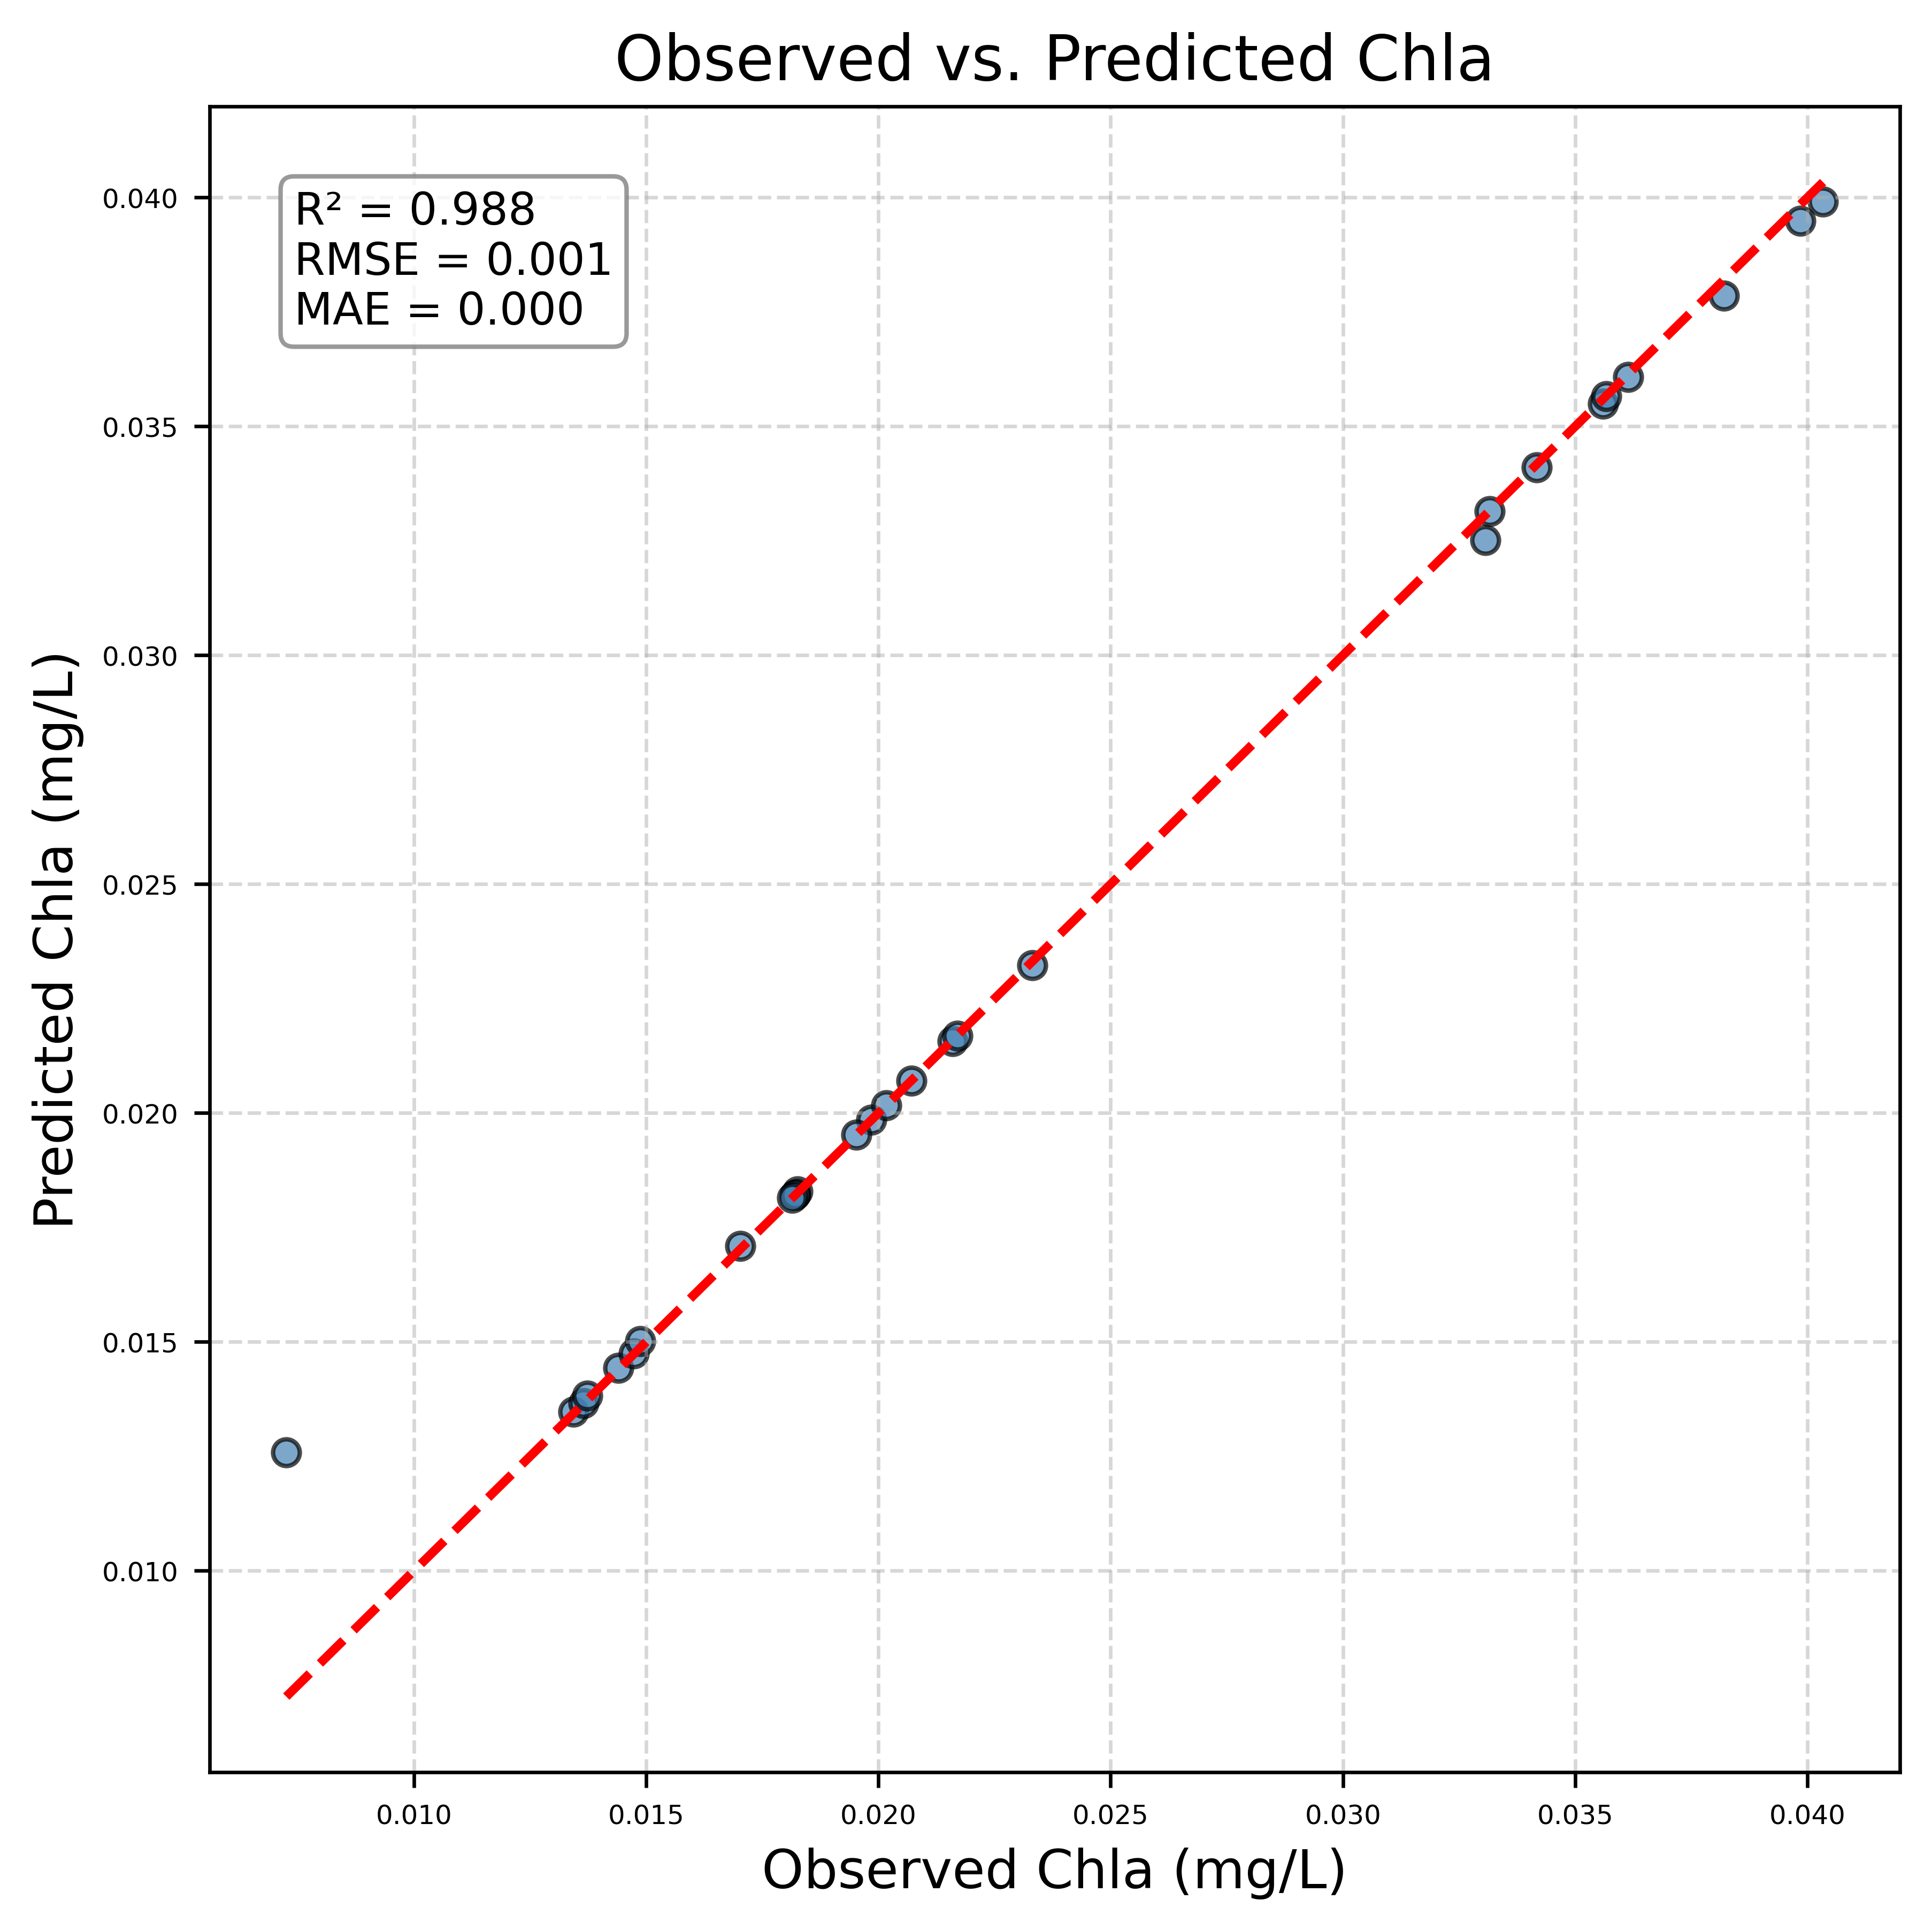

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Prediction results saved as Chla_Predictions_Chla.xlsx


In [ ]:
###############################
### 3.3: XGBoost Prediction ###
###############################

# ================= Import Required Libraries =================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from xgboost import XGBRegressor
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ================= Configuration Parameters =================
TARGET_VAR = "Chla"  # Target variable
DROP_COLS = ['T', 'DO', 'EC', 'ORP', 'pH', 'TDS']  # Variables to drop from X (adjust as needed)

# ================= Upload Dataset =================
data = pd.read_excel("LBanghu.xlsx")

# ================= Store Original Target for Evaluation =================
original_target = data[TARGET_VAR].copy()

# ================= Define Normality =================
normal_vars = ["TP", "pH", "ORP"]
non_normal_vars = ["T", "DO", "EC", "Chla", "TN", "TDS"]

# ================= Apply Quantile Transformation to Non-Normal Vars =================
transformer = QuantileTransformer(output_distribution='uniform', random_state=42, n_quantiles=len(data))
data[non_normal_vars] = transformer.fit_transform(data[non_normal_vars])

# ================= Clean the Data =================
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# ================= Feature and Target Definition =================
X = data.drop(columns=DROP_COLS + [TARGET_VAR] if TARGET_VAR in DROP_COLS else DROP_COLS)
y = data[TARGET_VAR]

# ================= Standardize Features =================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ================= Train XGBoost Model =================
model = XGBRegressor(
    learning_rate=0.05,
    max_depth=3,
    n_estimators=100,
    reg_lambda=1,
    random_state=42
)
model.fit(X_scaled, y)

# ================= Make Prediction =================
y_pred = model.predict(X_scaled)

# ================= Inverse Transform If Target Was Non-Normal =================
if TARGET_VAR in non_normal_vars:
    temp_df = data[non_normal_vars].copy()
    temp_df[TARGET_VAR] = y
    temp_df_pred = data[non_normal_vars].copy()
    temp_df_pred[TARGET_VAR] = y_pred

    y_original = transformer.inverse_transform(temp_df)[:, non_normal_vars.index(TARGET_VAR)]
    y_pred_original = transformer.inverse_transform(temp_df_pred)[:, non_normal_vars.index(TARGET_VAR)]
else:
    y_original = y
    y_pred_original = y_pred

# ================= Evaluation Metrics =================
r2 = r2_score(y_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_original, y_pred_original))
mae = mean_absolute_error(y_original, y_pred_original)

print(f"✅ Evaluation for {TARGET_VAR} (original scale) — R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# ================= Visualization =================
plt.figure(figsize=(6, 6), dpi=600)
plt.scatter(y_original, y_pred_original, alpha=0.7, color='steelblue', edgecolor='k')
plt.plot([y_original.min(), y_original.max()],
         [y_original.min(), y_original.max()],
         'r--', lw=2)

plt.xlabel(f'Observed {TARGET_VAR} (mg/L)', fontsize=12)
plt.ylabel(f'Predicted {TARGET_VAR} (mg/L)', fontsize=12)
plt.title(f'Observed vs. Predicted {TARGET_VAR}', fontsize=14)

# Text box for metrics
textstr = f'R² = {r2:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='left',
         bbox=props, fontsize=10)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f"{TARGET_VAR}_Observed_vs_Predicted.tiff", dpi=600, format='tiff')
plt.show()

# ================= Save and Export Results =================
results_df = pd.DataFrame({
    f'Actual_{TARGET_VAR}_Original': y_original,
    f'Predicted_{TARGET_VAR}_Original': y_pred_original
})
output_filename = f"{TARGET_VAR}_Predictions_Chla.xlsx"
results_df.to_excel(output_filename, index=False)
files.download(output_filename)
print(f"✅ Prediction results saved as {output_filename}")